In [1]:
#读取数据
#读取特征选择后的甲基化数据
import pandas as pd
MethylationFeature=pd.read_csv('/mnt/workspace/DNA methylation data/RA DNA methylation/RA_Methylation_Feature.csv')
MethylationFeature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6425 entries, 0 to 6424
Data columns (total 67 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           6425 non-null   int64  
 1   cg00455876           6425 non-null   float64
 2   cg05544622           6425 non-null   float64
 3   cg00423014           6425 non-null   float64
 4   cg00478198           6425 non-null   float64
 5   cg00776430           6425 non-null   float64
 6   cg01938887           6425 non-null   float64
 7   cg02714462           6425 non-null   float64
 8   cg02896361           6425 non-null   float64
 9   cg02971902           6425 non-null   float64
 10  cg03601619           6425 non-null   float64
 11  cg04029664           6425 non-null   float64
 12  cg04302300           6425 non-null   float64
 13  cg04699313           6425 non-null   float64
 14  cg05257372           6425 non-null   float64
 15  cg05443523           6425 non-null   f

In [2]:
MethylationFeature.isnull().sum().sum()    #检测空缺数据

0

Counter({'F': 3430, 'M': 2995})


<Axes: >

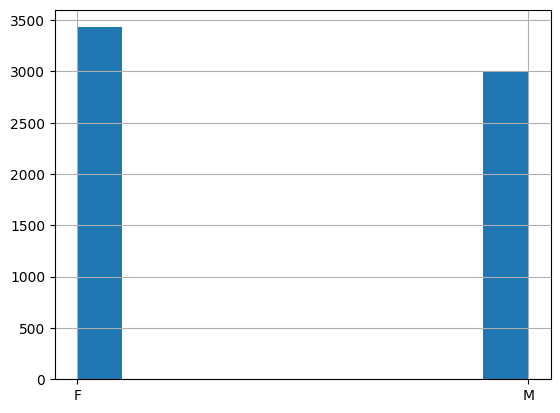

In [3]:
#统计性别数据
from collections import Counter
print(Counter(MethylationFeature['gender']))
MethylationFeature['gender'].hist()

Counter({'control': 6266, 'rheumatoid arthritis': 159})


<Axes: >

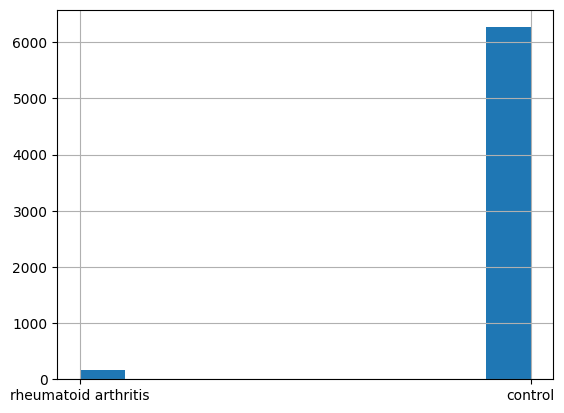

In [4]:
#统计疾病数据
print(Counter(MethylationFeature['disease']))
MethylationFeature['disease'].hist()

In [5]:
Methylation=MethylationFeature.iloc[:,1:-7]    #甲基化数据
MapData=MethylationFeature.loc[:,['age','GenderEncoder','DiseaseEncoder']]    #其他附加数据
MLData=pd.concat([Methylation,MapData],axis=1)    #数据合并
MLData.shape

(6425, 62)

测试不同方的性能差异：不使用数据重采样的SVM算法，使用数据重采样后的SVM算法.

In [12]:
#数据集划分
#切割数据
MLTestData=MLData.iloc[:,:-2]
MLTestLabel=MLData.iloc[:,-1]

In [17]:
MLTestData.shape

(6425, 60)

In [16]:
len(MLTestLabel)

6425

In [14]:
#数据归一化
from pandas import DataFrame
from sklearn.preprocessing import StandardScaler,MinMaxScaler
ColumnsNames=MLTestData.columns
Stand=StandardScaler()
StandData=Stand.fit_transform(MLTestData)
MinMax=MinMaxScaler(feature_range=(0,1))
MinMaxData=MinMax.fit_transform(StandData)
MLTestData=DataFrame(MinMaxData)
MLTestData.columns=ColumnsNames

不使用数据重采样算法，测试不同机器学习算法的性能。包括：Logisti回归、SVM、决策树、随机森林、XGBoost、LightGBM和CatBoost

In [7]:
#计算测试集PR曲线
from pandas import DataFrame
from sklearn.metrics import precision_recall_curve,accuracy_score
def PR_Curve(Model,Data,Label):
    X_train,X_test,y_train,y_test=train_test_split(Data,Label,train_size=0.7,random_state=2025)    #划分数据集
    predict_score=Model.predict_proba(X_test)[:, 1]    #获取概率值
    predict=Model.predict(X_test)     #获取预测标签
    accuracy=accuracy_score(y_test,predict)
    precision, recall, thresholds = precision_recall_curve(y_test, predict_score)    #计算PR曲线
    PR=DataFrame()    #将PR曲线数据合并到DataFrame
    #PR['thresholds']=thresholds
    PR['recall']=recall
    PR['precision']=precision
    return PR,accuracy

In [8]:
#计算测试集ROC曲线
from sklearn.metrics import roc_curve, auc
def ROC_Curve(Model,Data,Label):
    X_train,X_test,y_train,y_test=train_test_split(Data,Label,train_size=0.7,random_state=2025)    #划分数据集
    predict_score=Model.predict_proba(X_test)[:, 1]    #获取概率值
    fpr, tpr, thresholds = roc_curve(y_test, predict_score)
    roc_auc = auc(fpr, tpr)    #计算AUC
    ROC=DataFrame()    #将PR曲线数据合并到DataFrame
    #ROC['thresholds']=thresholds
    ROC['tpr']=tpr
    ROC['fpr']=fpr
    return ROC,roc_auc

In [6]:
#查看模型混淆矩阵
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
def Display_ConfusionMatrix(model,data,target):
    ConfusionMatrix_result=confusion_matrix(target,model.predict(data),labels=[0,1])    #计算混淆举证
    Display_ConfusionMatrix=ConfusionMatrixDisplay(ConfusionMatrix_result,display_labels=['control','rheumatoid arthritis'])
    Display_ConfusionMatrix.plot(include_values=True, cmap='viridis', xticks_rotation='horizontal', values_format='d', ax=None)
    plt.title('Confusion Matrix')
    plt.show()

In [9]:
#编写模型训练评估函数
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
def RunTestModel(Model,Data,Label):
    X_train,X_test,y_train,y_test=train_test_split(Data,Label,train_size=0.7,random_state=2024)    #划分数据集
    Model.fit(X_train,y_train)    #训练模型
    TrainPredict=Model.predict(X_train)    #计算训练集指标
    TrainPrecision=precision_score(y_train,TrainPredict)
    TrainRecall=recall_score(y_train,TrainPredict)
    TrainF1=f1_score(y_train,TrainPredict)
    TrainAcuracy=accuracy_score(y_train,TrainPredict)
    print('模型训练集Precision:{0},Recall:{1},F1_Score:{2},Accuracy:{3}'.format(TrainPrecision,TrainRecall,TrainF1,TrainAcuracy))
    TestPredict=Model.predict(X_test)    #测试集预测结果
    TestPrecision=precision_score(y_test,TestPredict)
    TestRecall=recall_score(y_test,TestPredict)
    TestF1=f1_score(y_test,TestPredict)
    TestAccuracy=accuracy_score(y_test,TestPredict)
    print('模型测试集Precision:{0},Recall:{1},F1_score:{2},Accuracy:{3}'.format(TestPrecision,TestRecall,TestF1,TestAccuracy))
    print('-------------------测试集混淆举证-------------------')
    Display_ConfusionMatrix(model=Model,data=X_test,target=y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


模型训练集Precision:0.0,Recall:0.0,F1_Score:0.0,Accuracy:0.9737602846342006
模型测试集Precision:1.0,Recall:0.023809523809523808,F1_score:0.046511627906976744,Accuracy:0.9787344398340249
-------------------测试集混淆举证-------------------


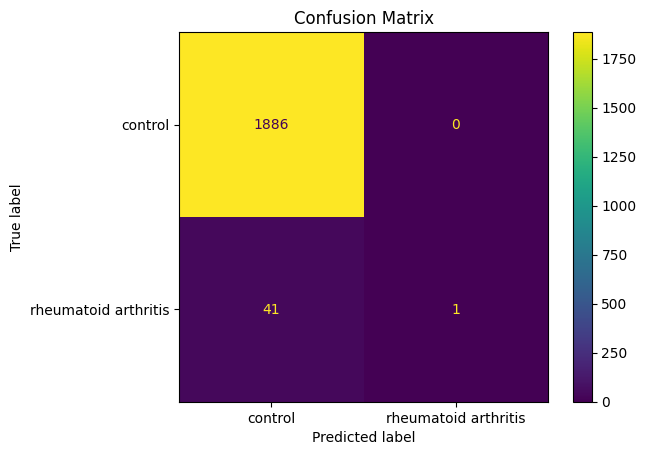

In [18]:
#测试Logistic回归
from sklearn.linear_model import LogisticRegression
Logistic=LogisticRegression(penalty="l2",dual=True,tol=1e-4,C=1.0,fit_intercept=True,random_state=2024,solver='liblinear',
                            max_iter=100,multi_class="auto",verbose=0, warm_start=False,n_jobs=-1,l1_ratio=None)
RunTestModel(Model=Logistic,Data=MLTestData,Label=MLTestLabel)

In [ ]:
#计算PR曲线和ROC曲线值
Logistic_PR,Logistic_Accuracy=PR_Curve(Model=Logistic,Data=MLTestData,Label=MLTestLabel)    
Logistic_ROC,Logistic_AUC=ROC_Curve(Model=Logistic,Data=MLTestData,Label=MLTestLabel)
#输出PR曲线和ROC曲线结果
Logistic_PR.to_excel('/mnt/workspace/Model test Module/No Resample Data/PR Curve Data/Logistic_PR.xlsx','UTF-8')
Logistic_ROC.to_excel('/mnt/workspace/Model test Module/No Resample Data/ROC Curve Data/Logistic_ROC.xlsx','UTF-8')

模型训练集Precision:0.0,Recall:0.0,F1_Score:0.0,Accuracy:0.9739826551034023
模型测试集Precision:0.0,Recall:0.0,F1_score:0.0,Accuracy:0.9782157676348547
-------------------测试集混淆举证-------------------


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


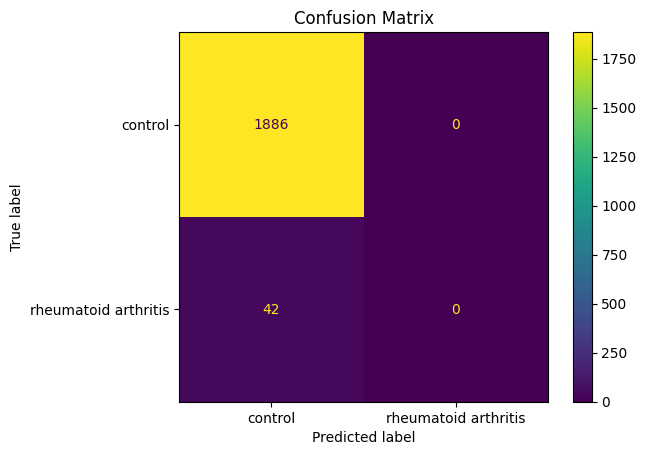

In [20]:
#测试SVM算法
from sklearn.svm import SVC
SVM_Classifier=SVC(C=1.0,kernel="rbf",degree=3,gamma="scale",coef0=0.0,shrinking=True,probability=True,tol=1e-3, 
                   cache_size=200,max_iter=-1, decision_function_shape="ovr",random_state=2024)
RunTestModel(Model=SVM_Classifier,Data=MLTestData,Label=MLTestLabel)

In [ ]:
#计算PR曲线和ROC曲线值
SVM_PR,SVM_Accuracy=PR_Curve(Model=SVM_Classifier,Data=MLTestData,Label=MLTestLabel)    
SVM_ROC,SVM_AUC=ROC_Curve(Model=SVM_Classifier,Data=MLTestData,Label=MLTestLabel)
#输出PR曲线和ROC曲线结果
SVM_PR.to_excel('/mnt/workspace/Model test Module/No Resample Data/PR Curve Data/SVM_PR.xlsx','UTF-8')
SVM_ROC.to_excel('/mnt/workspace/Model test Module/No Resample Data/ROC Curve Data/SVM_ROC.xlsx','UTF-8')

In [ ]:
#测试决策树算法
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.tree import 0.9719
DecisionTree=DecisionTreeClassifier(criterion='gini',splitter='best',max_depth=10,min_samples_split=2,random_state=2024)
Research_params={'max_depth':np.arange(1,20,1,dtype=int),'min_samples_split':np.arange(1,20,1,dtype=int),
                 'criterion':['gini','entropy']}    #超参数列表
GridSearch=GridSearchCV(estimator=DecisionTree,param_grid=Research_params,cv=5,
                        scoring='accuracy',return_train_score=True,n_jobs=-1,verbose=0)
GridSearch.fit(MLTestData,MLTestLabel)
print('超参数搜索最佳超参数为；',GridSearch.best_params_)
print('超参数搜索最佳得分为:',GridSearch.best_score_)
Best_DTC=GridSearch.best_estimator_

超参数搜索最佳超参数为； {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 13}

超参数搜索最佳得分为: 0.9757198443579765

模型训练集Precision:0.8192771084337349,Recall:0.5811965811965812,F1_Score:0.68,Accuracy:0.9857682899710919
模型测试集Precision:0.2857142857142857,Recall:0.19047619047619047,F1_score:0.22857142857142856,Accuracy:0.9719917012448133
-------------------测试集混淆举证-------------------


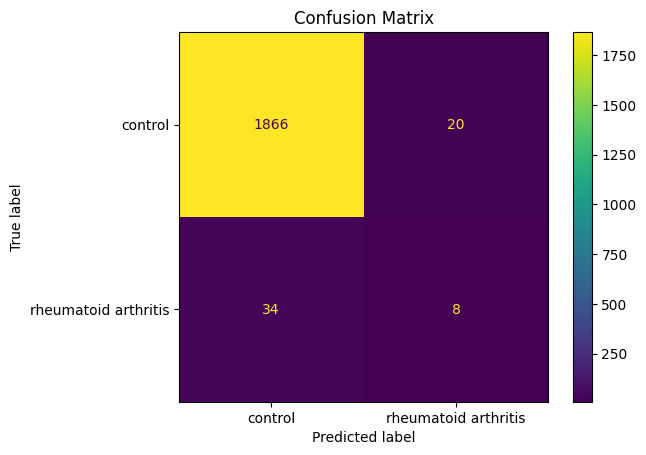

In [24]:
RunTestModel(Model=Best_DTC,Data=MLTestData,Label=MLTestLabel)

In [ ]:
#计算PR曲线和ROC曲线值
DTC_PR,DTC_Accuracy=PR_Curve(Model=Best_DTC,Data=MLTestData,Label=MLTestLabel)    
DTC_ROC,DTC_AUC=ROC_Curve(Model=Best_DTC,Data=MLTestData,Label=MLTestLabel)
#输出PR曲线和ROC曲线结果
DTC_PR.to_excel('/mnt/workspace/Model test Module/No Resample Data/PR Curve Data/DTC_PR.xlsx','UTF-8')
DTC_ROC.to_excel('/mnt/workspace/Model test Module/No Resample Data/ROC Curve Data/DTC_ROC.xlsx','UTF-8')

In [ ]:
#对随机森林进行网格搜索
from sklearn.ensemble import RandomForestClassifier
RandomForest=RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=7,min_samples_split=6,
                                    bootstrap=True,min_samples_leaf=2,max_features='auto',random_state=2024)
RandomForest_params={'n_estimators':np.arange(1,40,2,dtype=int),'min_samples_leaf':np.arange(1,40,2,dtype=int),
                     'max_features':['auto','sqrt'],'criterion':['gini','entropy']}
GridSearch_RandomForest=GridSearchCV(estimator=RandomForest,param_grid=RandomForest_params,cv=5,
                        scoring='accuracy',return_train_score=False,n_jobs=-1,verbose=0)
GridSearch_RandomForest.fit(MLTestData,MLTestLabel)
print('超参数搜索最佳超参数为；',GridSearch_RandomForest.best_params_)
print('超参数搜索最佳得分为:',GridSearch_RandomForest.best_score_)
Best_Forest=GridSearch_RandomForest.best_estimator_

超参数搜索最佳超参数为； {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 11}

超参数搜索最佳得分为: 0.9771206225680933

模型训练集Precision:1.0,Recall:0.4188034188034188,F1_Score:0.5903614457831325,Accuracy:0.9848788080942851
模型测试集Precision:0.0,Recall:0.0,F1_score:0.0,Accuracy:0.9771784232365145
-------------------测试集混淆举证-------------------


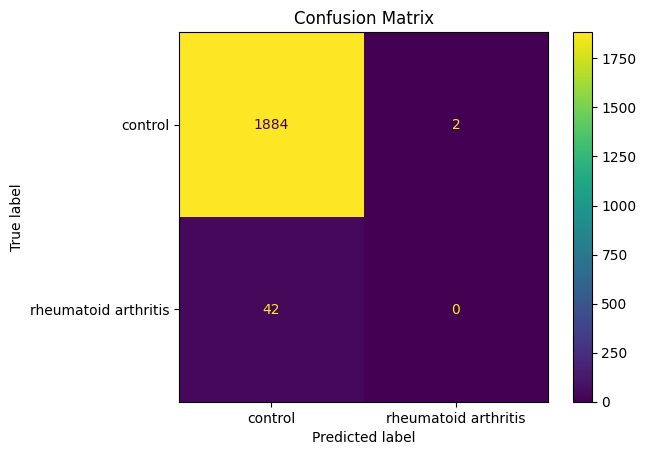

In [27]:
RunTestModel(Model=Best_Forest,Data=MLTestData,Label=MLTestLabel)

In [ ]:
#计算PR曲线和ROC曲线值
RondomForest_PR,RondomForest_Accuracy=PR_Curve(Model=Best_Forest,Data=MLTestData,Label=MLTestLabel)    
RondomForest_ROC,RondomForest_AUC=ROC_Curve(Model=Best_Forest,Data=MLTestData,Label=MLTestLabel)
#输出PR曲线和ROC曲线结果
RondomForest_PR.to_excel('/mnt/workspace/Model test Module/No Resample Data/PR Curve Data/RondomForest_PR.xlsx','UTF-8')
RondomForest_ROC.to_excel('/mnt/workspace/Model test Module/No Resample Data/ROC Curve Data/RondomForest_ROC.xlsx','UTF-8')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:48:05] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)


模型训练集Precision:1.0,Recall:1.0,F1_Score:1.0,Accuracy:1.0
模型测试集Precision:0.625,Recall:0.47619047619047616,F1_score:0.5405405405405406,Accuracy:0.9823651452282157
-------------------测试集混淆举证-------------------


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:48:06] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


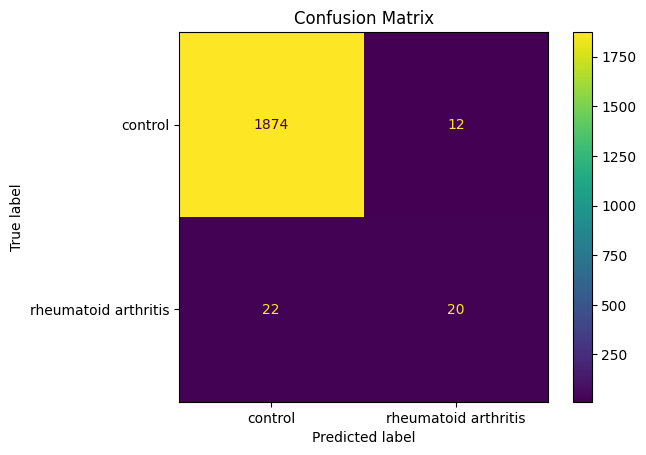

In [29]:
#测试XGBoost模型
from xgboost import XGBClassifier
XGBoost=XGBClassifier(n_jobs=-1,verbosity=1,tree_method='auto',gpu_id=0,random_state=2025)
RunTestModel(Model=XGBoost,Data=MLTestData,Label=MLTestLabel)

In [ ]:
#计算PR曲线和ROC曲线值
XGBoost_PR,XGBoost_Accuracy=PR_Curve(Model=XGBoost,Data=MLTestData,Label=MLTestLabel)    
XGBoost_ROC,XGBoost_AUC=ROC_Curve(Model=XGBoost,Data=MLTestData,Label=MLTestLabel)
#输出PR曲线和ROC曲线结果
XGBoost_PR.to_excel('/mnt/workspace/Model test Module/No Resample Data/PR Curve Data/XGBoost_PR.xlsx','UTF-8')
XGBoost_ROC.to_excel('/mnt/workspace/Model test Module/No Resample Data/ROC Curve Data/XGBoost_ROC.xlsx','UTF-8')

[LightGBM] [Warning] Unknown parameter: keep_training_booster
[LightGBM] [Warning] Unknown parameter: keep_training_booster
[LightGBM] [Info] Number of positive: 117, number of negative: 4380
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12458
[LightGBM] [Info] Number of data points in the train set: 4497, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.026017 -> initscore=-3.622630
[LightGBM] [Info] Start training from score -3.622630
[LightGBM] [Warning] Unknown parameter: keep_training_booster
模型训练集Precision:1.0,Recall:0.9829059829059829,F1_Score:0.9913793103448276,Accuracy:0.9995552590615966
[LightGBM] [Warning] Unknown parameter: keep_training_booster
模型测试集Precision:0.5714285714285714,Recall:0.2857142857142857,F1_score:0.38095238095238093,Accuracy:0.9797717842323651
-------------------测试集混淆举证-----------------

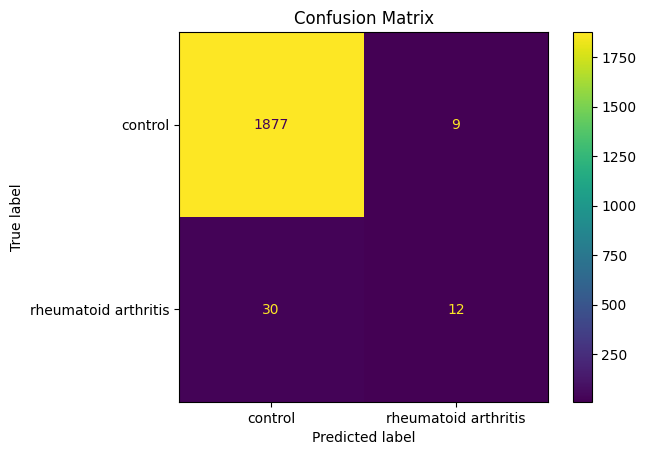

In [31]:
#测试LightGBM算法
from lightgbm import LGBMClassifier
LightGBM=LGBMClassifier(boosting_type='gbdt',num_leaves=31,learning_rate=0.01,n_estimators=200,
                        n_jobs=-1,objective='binary',metric='binary_logloss',keep_training_booster=True,
                       importance_type='gini',random_state=2025)
RunTestModel(Model=LightGBM,Data=MLTestData,Label=MLTestLabel)

In [ ]:
#计算PR曲线和ROC曲线值
LightGBM_PR,LightGBM_Accuracy=PR_Curve(Model=LightGBM,Data=MLTestData,Label=MLTestLabel)    
LightGBM_ROC,LightGBM_AUC=ROC_Curve(Model=LightGBM,Data=MLTestData,Label=MLTestLabel)
#输出PR曲线和ROC曲线结果
LightGBM_PR.to_excel('/mnt/workspace/Model test Module/No Resample Data/PR Curve Data/LightGBM_PR.xlsx','UTF-8')
LightGBM_ROC.to_excel('/mnt/workspace/Model test Module/No Resample Data/ROC Curve Data/LightGBM_ROC.xlsx','UTF-8')

0:	learn: 0.6739162	total: 51.7ms	remaining: 25.8s
1:	learn: 0.6564726	total: 55.4ms	remaining: 13.8s
2:	learn: 0.6366456	total: 58.7ms	remaining: 9.73s
3:	learn: 0.6199755	total: 62.1ms	remaining: 7.7s
4:	learn: 0.6036810	total: 65.5ms	remaining: 6.48s
5:	learn: 0.5875139	total: 68.9ms	remaining: 5.68s
6:	learn: 0.5727919	total: 72.2ms	remaining: 5.09s
7:	learn: 0.5571492	total: 75.6ms	remaining: 4.65s
8:	learn: 0.5409595	total: 79.1ms	remaining: 4.31s
9:	learn: 0.5265754	total: 82.5ms	remaining: 4.04s
10:	learn: 0.5132621	total: 85.9ms	remaining: 3.82s
11:	learn: 0.4966932	total: 89.3ms	remaining: 3.63s
12:	learn: 0.4844744	total: 92.6ms	remaining: 3.47s
13:	learn: 0.4721330	total: 95.9ms	remaining: 3.33s
14:	learn: 0.4583173	total: 99.1ms	remaining: 3.2s
15:	learn: 0.4445007	total: 102ms	remaining: 3.09s
16:	learn: 0.4345071	total: 105ms	remaining: 2.99s
17:	learn: 0.4239666	total: 108ms	remaining: 2.9s
18:	learn: 0.4130576	total: 112ms	remaining: 2.83s
19:	learn: 0.4018345	total: 1

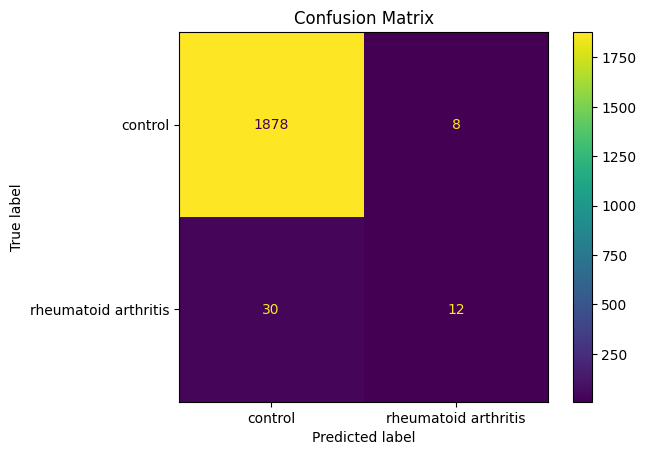

In [33]:
#测试CatBoost算法
from catboost import CatBoostClassifier
CatBoost=CatBoostClassifier(learning_rate=0.01,depth=6,iterations=500,thread_count=-1)
RunTestModel(Model=CatBoost,Data=MLTestData,Label=MLTestLabel)

In [ ]:
#计算PR曲线和ROC曲线值
CatBoost_PR,CatBoost_Accuracy=PR_Curve(Model=CatBoost,Data=MLTestData,Label=MLTestLabel)    
CatBoost_ROC,CatBoost_AUC=ROC_Curve(Model=CatBoost,Data=MLTestData,Label=MLTestLabel)
#输出PR曲线和ROC曲线结果
CatBoost_PR.to_excel('/mnt/workspace/Model test Module/No Resample Data/PR Curve Data/CatBoost_PR.xlsx','UTF-8')
CatBoost_ROC.to_excel('/mnt/workspace/Model test Module/No Resample Data/ROC Curve Data/CatBoost_ROC.xlsx','UTF-8')

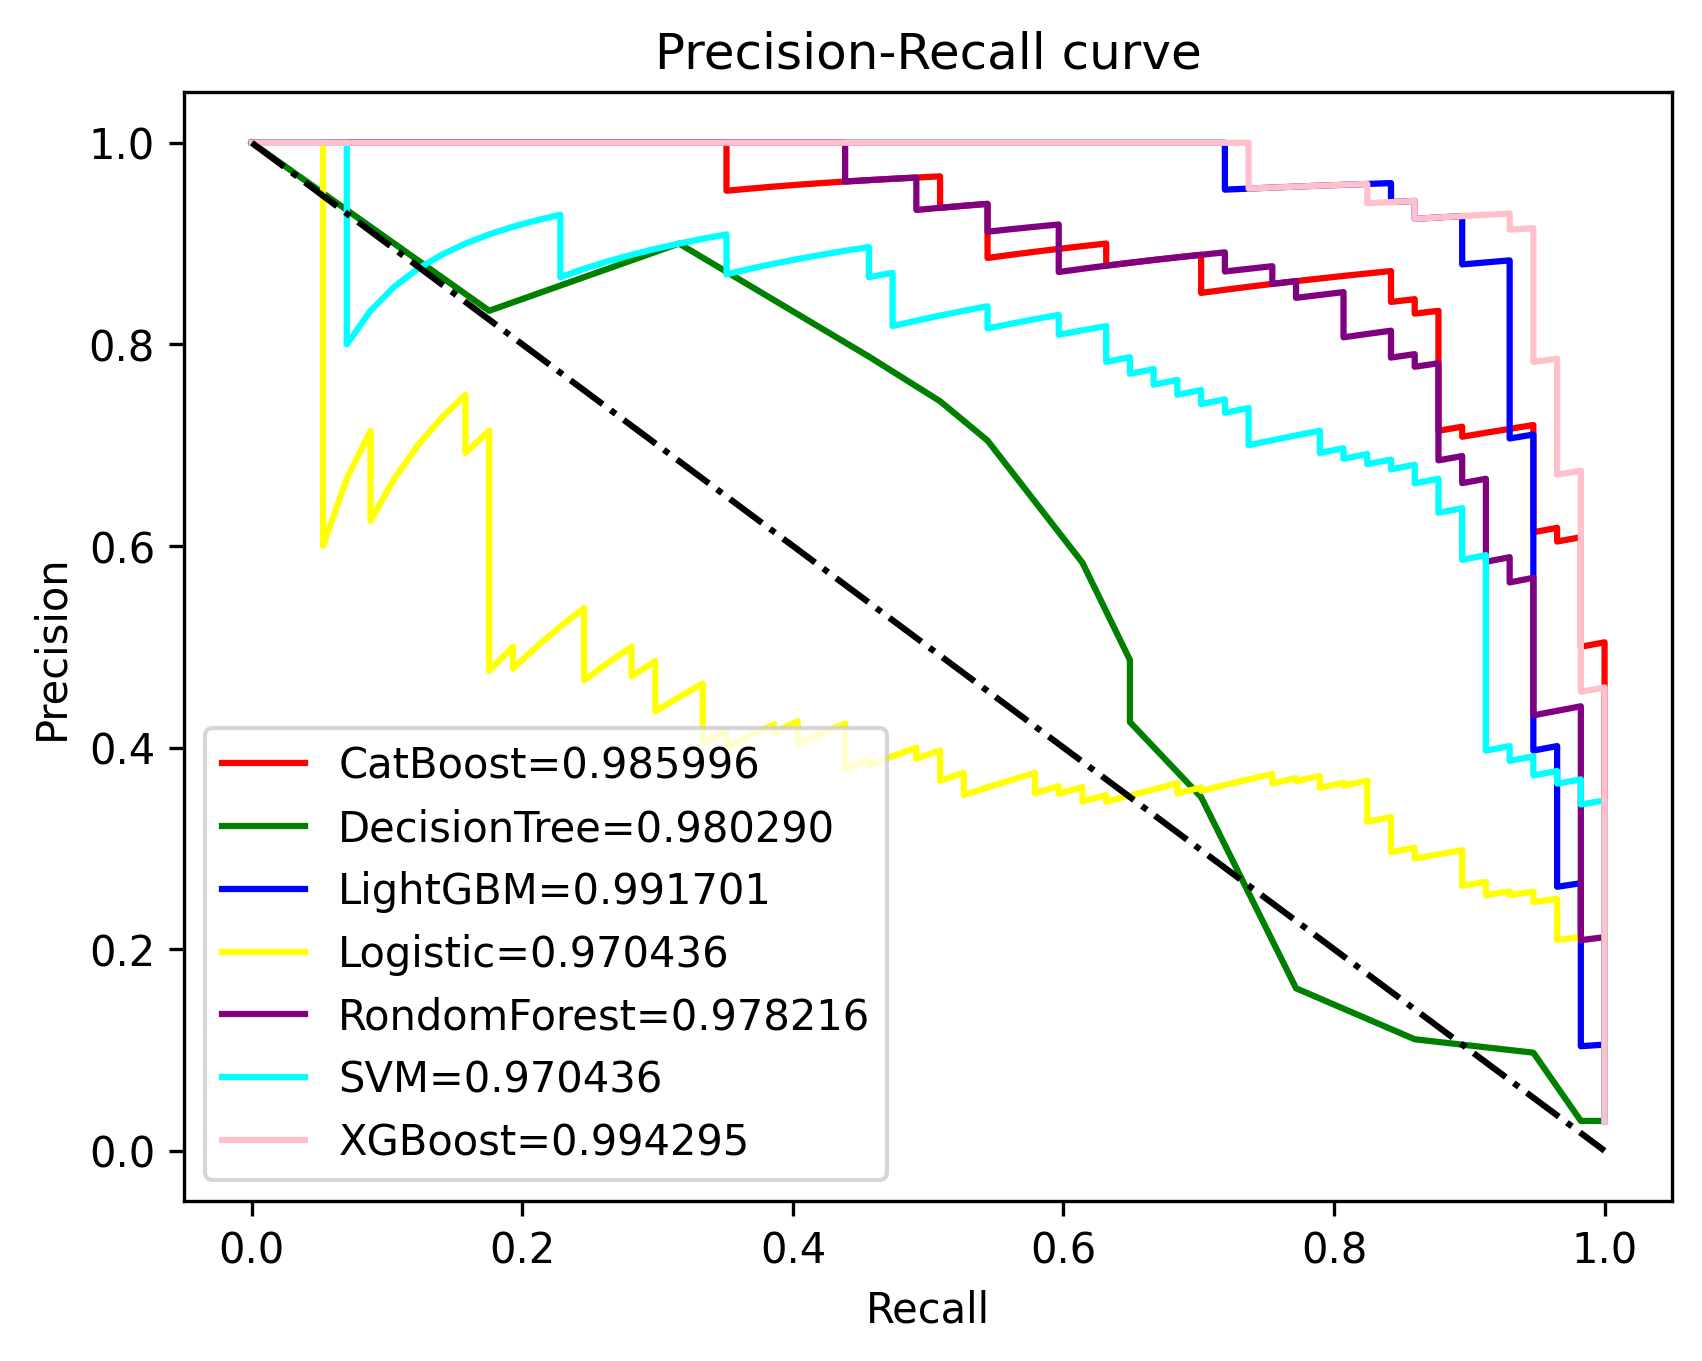

In [35]:
#绘制PR曲线
import matplotlib.pyplot as plt
PR_curve=plt.figure(dpi=300)
PR_ax=PR_curve.add_subplot(111)
PR_ax.set_title('Precision-Recall curve')
PR_ax.plot(CatBoost_PR['recall'], CatBoost_PR['precision'],color='red',label='CatBoost=%f'%CatBoost_Accuracy)
PR_ax.plot(DTC_PR['recall'], DTC_PR['precision'],color='green',label='DecisionTree=%f'%DTC_Accuracy)
PR_ax.plot(LightGBM_PR['recall'], LightGBM_PR['precision'],color='blue',label='LightGBM=%f'%LightGBM_Accuracy)
PR_ax.plot(Logistic_PR['recall'], Logistic_PR['precision'],color='yellow',label='Logistic=%f'%Logistic_Accuracy)
PR_ax.plot(RondomForest_PR['recall'], RondomForest_PR['precision'],color='purple',label='RondomForest=%f'%RondomForest_Accuracy)
PR_ax.plot(SVM_PR['recall'], SVM_PR['precision'],color='cyan',label='SVM=%f'%SVM_Accuracy)
PR_ax.plot(XGBoost_PR['recall'], XGBoost_PR['precision'],color='pink',label='XGBoost=%f'%XGBoost_Accuracy)
PR_ax.plot([0,1],[1,0],linestyle='-.',color='black')
PR_ax.set_xlabel('Recall')  
PR_ax.set_ylabel('Precision')    
plt.legend(loc="best")  
plt.show()

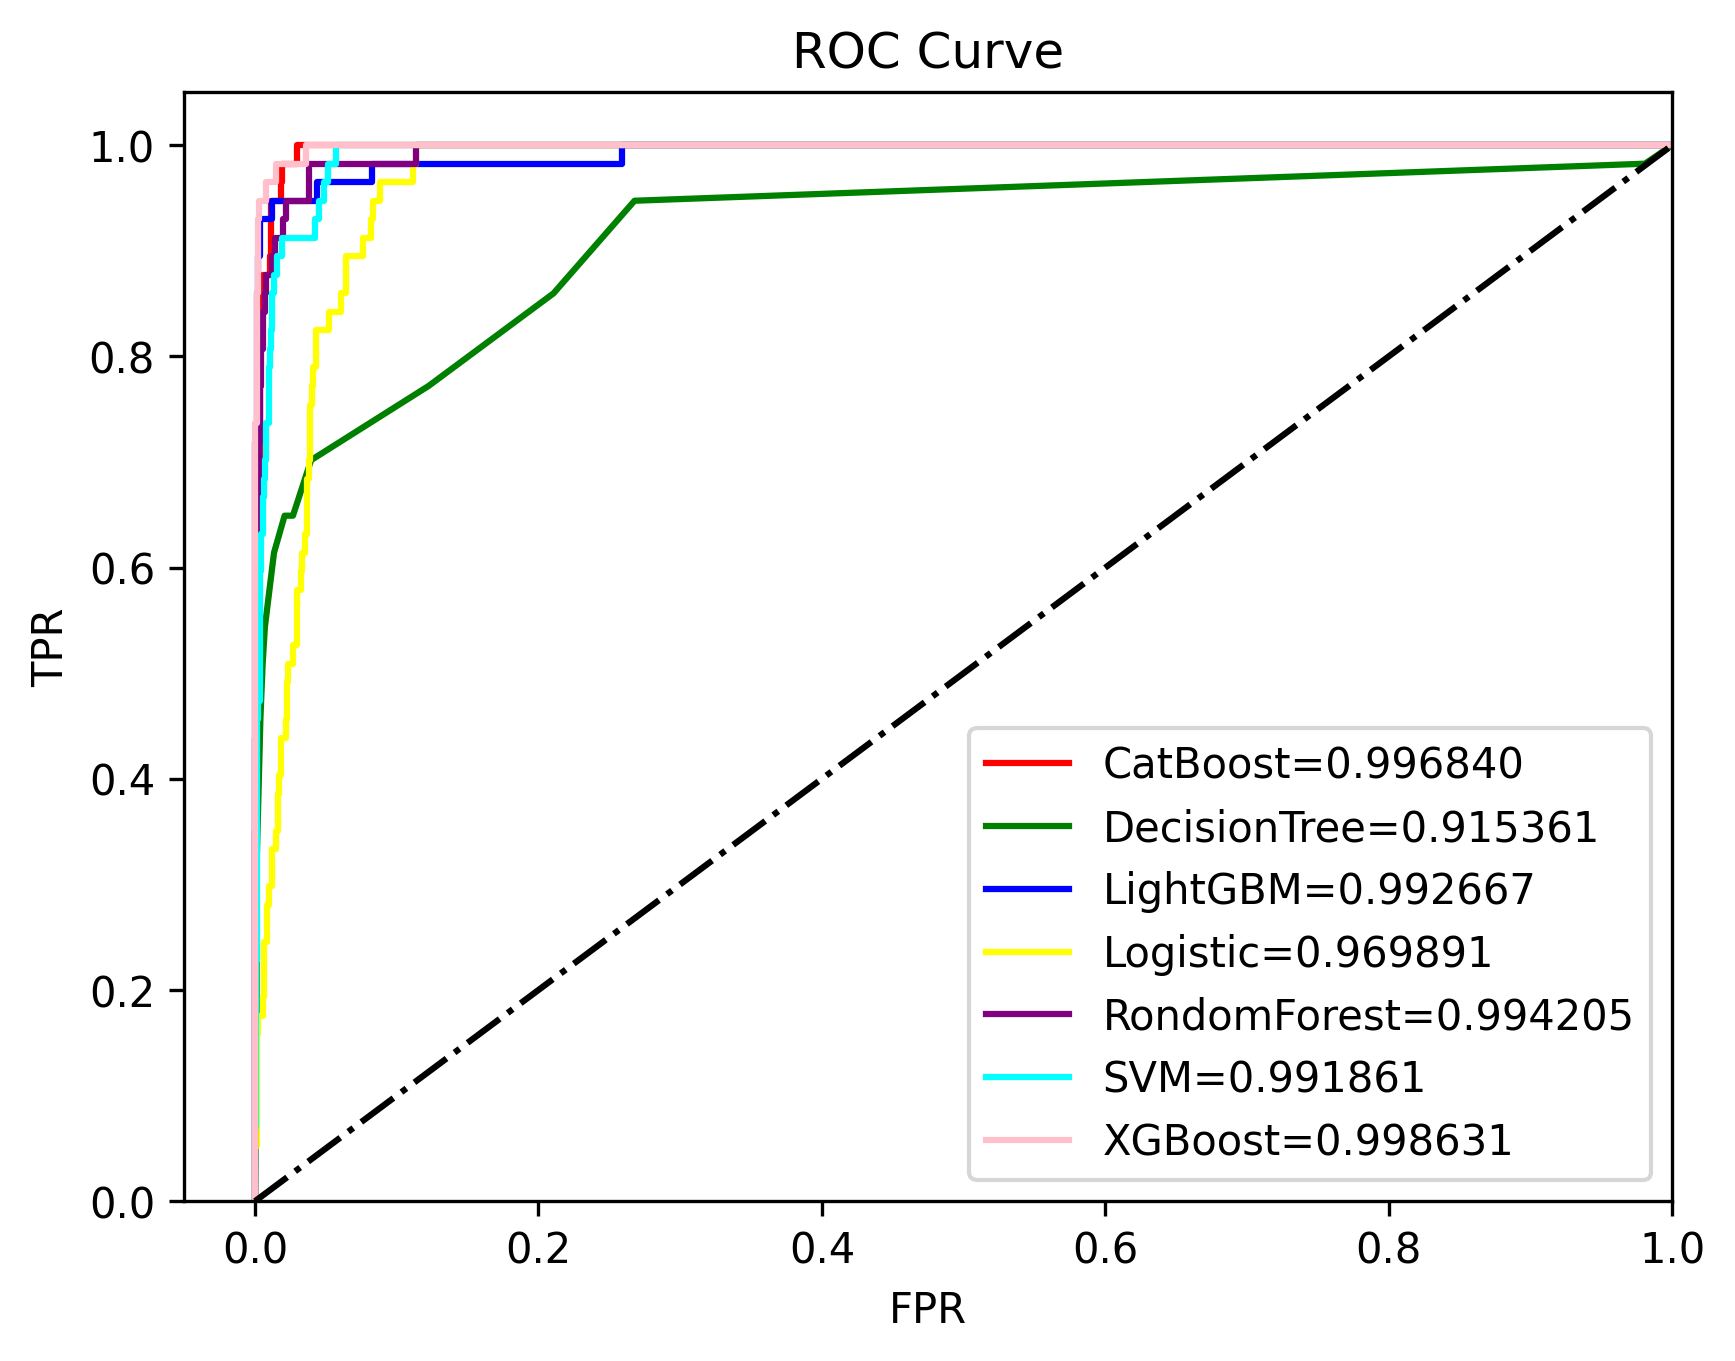

In [36]:
#绘制ROC曲线
import matplotlib.pyplot as plt
ROC_curve=plt.figure(dpi=300)
ROC_ax=ROC_curve.add_subplot(111)
ROC_ax.set_title('ROC Curve')
ROC_ax.plot(CatBoost_ROC['fpr'], CatBoost_ROC['tpr'],color='red',label='CatBoost=%f'%CatBoost_AUC)
ROC_ax.plot(DTC_ROC['fpr'], DTC_ROC['tpr'],color='green',label='DecisionTree=%f'%DTC_AUC)
ROC_ax.plot(LightGBM_ROC['fpr'], LightGBM_ROC['tpr'],color='blue',label='LightGBM=%f'%LightGBM_AUC)
ROC_ax.plot(Logistic_ROC['fpr'], Logistic_ROC['tpr'],color='yellow',label='Logistic=%f'%Logistic_AUC)
ROC_ax.plot(RondomForest_ROC['fpr'], RondomForest_ROC['tpr'],color='purple',label='RondomForest=%f'%RondomForest_AUC)
ROC_ax.plot(SVM_ROC['fpr'], SVM_ROC['tpr'],color='cyan',label='SVM=%f'%SVM_AUC)
ROC_ax.plot(XGBoost_ROC['fpr'], XGBoost_ROC['tpr'],color='pink',label='XGBoost=%f'%XGBoost_AUC)
ROC_ax.plot([0,1],[0,1],linestyle='-.',color='black')
ROC_ax.set_xlim([-0.05, 1.0])  
ROC_ax.set_ylim([0, 1.05])  
ROC_ax.set_xlabel('FPR')  
ROC_ax.set_ylabel('TPR')    
plt.legend(loc="best")  
plt.show()

In [37]:
#保存模型-输入[batchs,61],输出[batch,1]
import joblib
MLModel=[Logistic,SVM_Classifier,Best_DTC,Best_Forest,XGBoost,LightGBM,CatBoost]
MLModelStr=['Logistic.pkl','SVM.pkl','DecisionTree.pkl','Forest.pkl','XGBoost.pkl','LightGBM.pkl','CatBoost.pkl']
try:
    for model,modelstr in zip(MLModel,MLModelStr):
        joblib.dump(model,'/mnt/workspace/Model test Module/No Resmaple Model/'+modelstr)
    print('模型保存成功！')
except:
    print('模型保存异常！！！')

模型保存成功！


测试数据重采样算法，以XGBoost模型为基准。

In [38]:
#使用CNN算法进行欠采样
from imblearn.under_sampling import CondensedNearestNeighbour
CNN=CondensedNearestNeighbour(sampling_strategy='not minority',random_state=2024,n_jobs=-1)
CNN_TestData,CNN_TestLabel=CNN.fit_resample(MLTestData,MLTestLabel)
Counter(CNN_TestLabel)

Counter({0: 357, 1: 159})

In [ ]:
CNNResampleData=pd.concat([CNN_TestData,CNN_TestLabel],axis=1)
CNNResampleData.to_excel('/mnt/workspace/Model test Module/Resample Data/Resample Data/CNN Resample Data.xlsx','UTF-8')

模型训练集Precision:1.0,Recall:1.0,F1_Score:1.0,Accuracy:1.0
模型测试集Precision:0.5957446808510638,Recall:0.6666666666666666,F1_score:0.6292134831460674,Accuracy:0.7870967741935484
-------------------测试集混淆举证-------------------


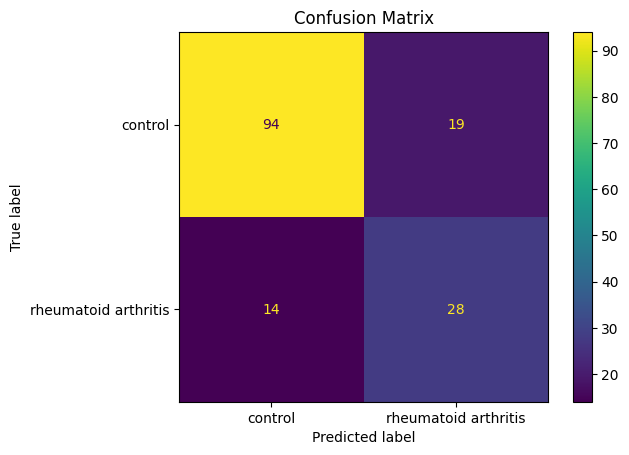

In [39]:
XGBoostCNN=XGBClassifier(n_jobs=-1,verbosity=1,tree_method='auto',gpu_id=0,random_state=2025)
RunTestModel(Model=XGBoostCNN,Data=CNN_TestData,Label=CNN_TestLabel)

In [40]:
#计算PR曲线和ROC曲线
CNN_RF_PR,CNN_RF_Accuracy=PR_Curve(Model=XGBoostCNN,Data=CNN_TestData,Label=CNN_TestLabel)
CNN_RF_ROC,CNN_RF_AUC=ROC_Curve(Model=XGBoostCNN,Data=CNN_TestData,Label=CNN_TestLabel)
#输出相关数据
CNN_RF_PR.to_excel('/mnt/workspace/Model test Module/Resample Data/PR Curve Data/CNN_RF_PR.xlsx')
CNN_RF_ROC.to_excel('/mnt/workspace/Model test Module/Resample Data/ROC Curve Data/CNN_RF_ROC.xlsx')

In [41]:
#使用IHT算法进行欠采样
from imblearn.under_sampling import 0.8712
IHT=InstanceHardnessThreshold(random_state=2024,cv=5,n_jobs=-1)
IHT_TestData,IHT_TestLabel=IHT.fit_resample(MLTestData,MLTestLabel)
Counter(IHT_TestLabel)

Counter({0: 3748, 1: 159})

In [ ]:
IHTResampleData=pd.concat([IHT_TestData,IHT_TestLabel],axis=1)
IHTResampleData.to_excel('/mnt/workspace/Model test Module/Resample Data/Resample Data/IHT Resample Data.xlsx','UTF-8')

模型训练集Precision:1.0,Recall:1.0,F1_Score:1.0,Accuracy:1.0
模型测试集Precision:1.0,Recall:0.7719298245614035,F1_score:0.8712871287128713,Accuracy:0.9889173060528559
-------------------测试集混淆举证-------------------


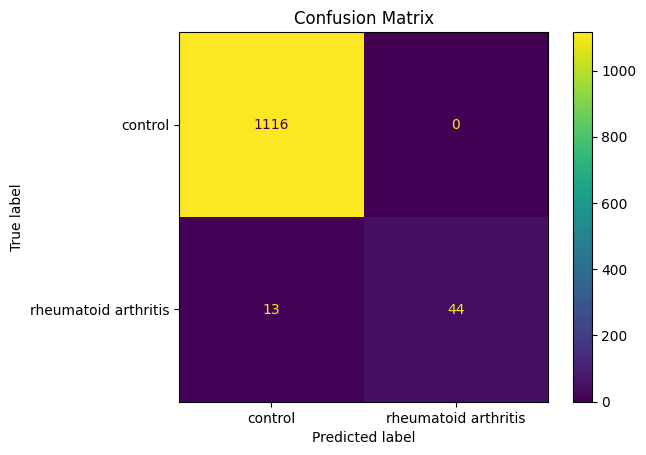

In [42]:
XGBoostIHT=XGBClassifier(n_jobs=-1,verbosity=1,tree_method='auto',gpu_id=0,random_state=2025)
RunTestModel(Model=XGBoostIHT,Data=IHT_TestData,Label=IHT_TestLabel)

In [43]:
IHT_RF_PR,IHT_RF_Accuracy=PR_Curve(Model=XGBoostIHT,Data=IHT_TestData,Label=IHT_TestLabel)
IHT_RF_ROC,IHT_RF_AUC=ROC_Curve(Model=XGBoostIHT,Data=IHT_TestData,Label=IHT_TestLabel)
#输出相关数据
IHT_RF_PR.to_excel('/mnt/workspace/Model test Module/Resample Data/PR Curve Data/IHT_RF_PR.xlsx')
IHT_RF_ROC.to_excel('/mnt/workspace/Model test Module/Resample Data/ROC Curve Data/IHT_RF_ROC.xlsx')

In [44]:
#使用NearMiss进行欠采样
from imblearn.under_sampling import NearMiss
NM=NearMiss(sampling_strategy='not minority',n_jobs=-1)
NM_TestData,NM_TestLabel=NM.fit_resample(MLTestData,MLTestLabel)
Counter(NM_TestLabel)

Counter({0: 159, 1: 159})

In [64]:
NMResampleData=pd.concat([NM_TestData,NM_TestLabel],axis=1)
NMResampleData.to_excel('/mnt/workspace/Model test Module/Resample Data/Resample Data/NM Resample Data.xlsx','UTF-8')

/tmp/ipykernel_352/897216993.py:2: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  NMResampleData.to_excel('/mnt/workspace/Model test Module/Resample Data/Resample Data/NM Resample Data.xlsx','UTF-8')


模型训练集Precision:1.0,Recall:1.0,F1_Score:1.0,Accuracy:1.0
模型测试集Precision:0.8421052631578947,Recall:0.9056603773584906,F1_score:0.8727272727272727,Accuracy:0.8541666666666666
-------------------测试集混淆举证-------------------


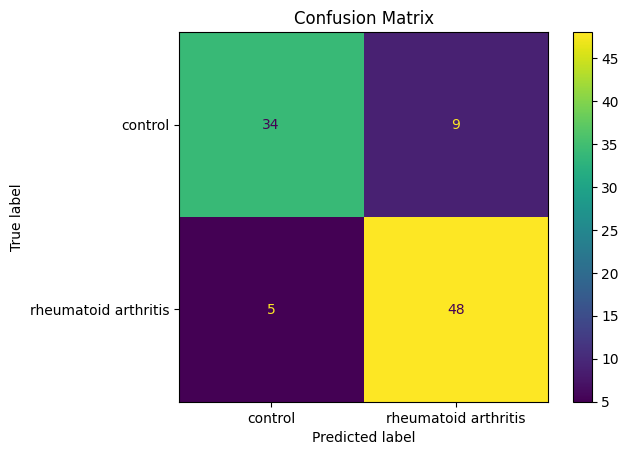

In [45]:
XGBoostNM=XGBClassifier(n_jobs=-1,verbosity=1,tree_method='auto',gpu_id=0,random_state=2025)
RunTestModel(Model=XGBoostNM,Data=NM_TestData,Label=NM_TestLabel)

In [46]:
NM_RF_PR,NM_RF_Accuracy=PR_Curve(Model=XGBoostNM,Data=NM_TestData,Label=NM_TestLabel)
NM_RF_ROC,NM_RF_AUC=ROC_Curve(Model=XGBoostNM,Data=NM_TestData,Label=NM_TestLabel)
#输出相关数据
NM_RF_PR.to_excel('/mnt/workspace/Model test Module/Resample Data/PR Curve Data/NM_RF_PR.xlsx')
NM_RF_ROC.to_excel('/mnt/workspace/Model test Module/Resample Data/ROC Curve Data/NM_RF_ROC.xlsx')

In [47]:
#使用NeighbourhoodCleaningRule进行欠采样
from imblearn.under_sampling import NeighbourhoodCleaningRule
NBC=NeighbourhoodCleaningRule(sampling_strategy='not minority',n_jobs=-1)
NBC_TestData,NBC_TestLabel=NBC.fit_resample(MLTestData,MLTestLabel)
Counter(NBC_TestLabel)

Counter({0: 6105, 1: 159})

In [65]:
NBCResampleData=pd.concat([NBC_TestData,NBC_TestLabel],axis=1)
NBCResampleData.to_excel('/mnt/workspace/Model test Module/Resample Data/Resample Data/NBC Resample Data.xlsx','UTF-8')

/tmp/ipykernel_352/696897540.py:2: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  NBCResampleData.to_excel('/mnt/workspace/Model test Module/Resample Data/Resample Data/NBC Resample Data.xlsx','UTF-8')


模型训练集Precision:1.0,Recall:1.0,F1_Score:1.0,Accuracy:1.0
模型测试集Precision:0.84,Recall:0.5121951219512195,F1_score:0.6363636363636364,Accuracy:0.9872340425531915
-------------------测试集混淆举证-------------------


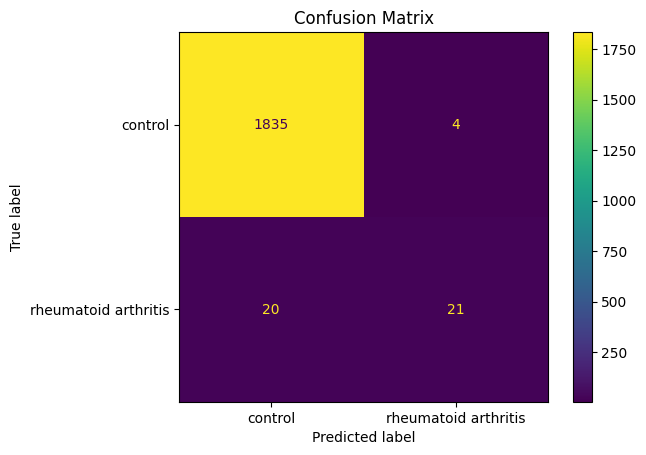

In [48]:
XGBoostNBC=XGBClassifier(n_jobs=-1,verbosity=1,tree_method='auto',gpu_id=0,random_state=2025)
RunTestModel(Model=XGBoostNBC,Data=NBC_TestData,Label=NBC_TestLabel)

In [49]:
NBC_RF_PR,NBC_RF_Accuracy=PR_Curve(Model=XGBoostNBC,Data=NBC_TestData,Label=NBC_TestLabel)
NBC_RF_ROC,NBC_RF_AUC=ROC_Curve(Model=XGBoostNBC,Data=NBC_TestData,Label=NBC_TestLabel)
#输出相关数据
NBC_RF_PR.to_excel('/mnt/workspace/Model test Module/Resample Data/PR Curve Data/NBC_RF_PR.xlsx')
NBC_RF_ROC.to_excel('/mnt/workspace/Model test Module/Resample Data/ROC Curve Data/NBC_RF_ROC.xlsx')

In [50]:
#使用OneSidedSelection进行欠采样
from imblearn.under_sampling import OneSidedSelection
OSS=OneSidedSelection(sampling_strategy='not minority',random_state=2024,n_jobs=-1)
OSS_TestData,OSS_TestLabel=OSS.fit_resample(MLTestData,MLTestLabel)
Counter(OSS_TestLabel)

Counter({0: 6165, 1: 159})

In [66]:
OSSResampleData=pd.concat([OSS_TestData,OSS_TestLabel],axis=1)
OSSResampleData.to_excel('/mnt/workspace/Model test Module/Resample Data/Resample Data/OSS Resample Data.xlsx','UTF-8')

/tmp/ipykernel_352/460341160.py:2: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  OSSResampleData.to_excel('/mnt/workspace/Model test Module/Resample Data/Resample Data/OSS Resample Data.xlsx','UTF-8')


模型训练集Precision:1.0,Recall:1.0,F1_Score:1.0,Accuracy:1.0
模型测试集Precision:0.8214285714285714,Recall:0.39655172413793105,F1_score:0.5348837209302325,Accuracy:0.9789251844046365
-------------------测试集混淆举证-------------------


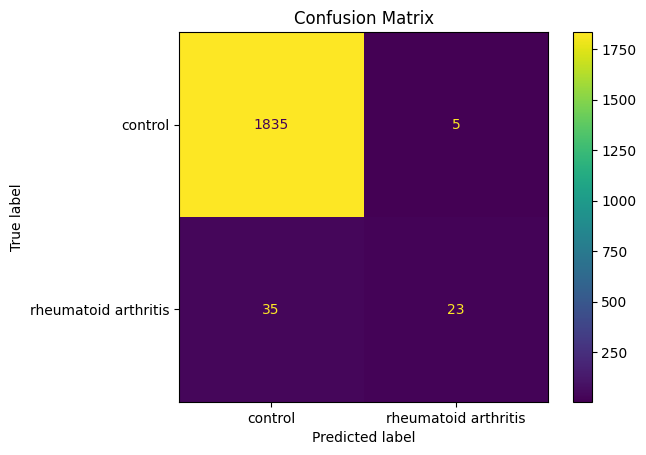

In [51]:
XGBoostOSS=XGBClassifier(n_jobs=-1,verbosity=1,tree_method='auto',gpu_id=0,random_state=2025)
RunTestModel(Model=XGBoostOSS,Data=OSS_TestData,Label=OSS_TestLabel)

In [52]:
OSS_RF_PR,OSS_RF_Accuracy=PR_Curve(Model=XGBoostOSS,Data=OSS_TestData,Label=OSS_TestLabel)
OSS_RF_ROC,OSS_RF_AUC=ROC_Curve(Model=XGBoostOSS,Data=OSS_TestData,Label=OSS_TestLabel)
#输出相关数据
OSS_RF_PR.to_excel('/mnt/workspace/Model test Module/Resample Data/PR Curve Data/OSS_RF_PR.xlsx')
OSS_RF_ROC.to_excel('/mnt/workspace/Model test Module/Resample Data/ROC Curve Data/OSS_RF_ROC.xlsx')

In [53]:
#使用随机欠采样进行数据欠采样
from imblearn.under_sampling import RandomUnderSampler
RUS=RandomUnderSampler(sampling_strategy='not minority',random_state=2024)
RUS_TestData,RUS_TestLabel=RUS.fit_resample(MLTestData,MLTestLabel)
Counter(RUS_TestLabel)

Counter({0: 159, 1: 159})

In [67]:
RUSResampleData=pd.concat([RUS_TestData,RUS_TestLabel],axis=1)
RUSResampleData.to_excel('/mnt/workspace/Model test Module/Resample Data/Resample Data/IHT Resample Data.xlsx','UTF-8')

/tmp/ipykernel_352/3364870921.py:2: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  RUSResampleData.to_excel('/mnt/workspace/Model test Module/Resample Data/Resample Data/IHT Resample Data.xlsx','UTF-8')


模型训练集Precision:1.0,Recall:1.0,F1_Score:1.0,Accuracy:1.0
模型测试集Precision:0.9285714285714286,Recall:0.9811320754716981,F1_score:0.9541284403669725,Accuracy:0.9479166666666666
-------------------测试集混淆举证-------------------


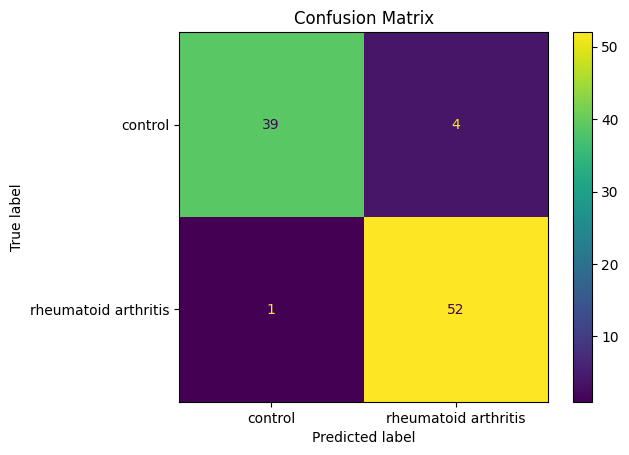

In [54]:
XGBoostRUS=XGBClassifier(n_jobs=-1,verbosity=1,tree_method='auto',gpu_id=0,random_state=2025)
RunTestModel(Model=XGBoostRUS,Data=RUS_TestData,Label=RUS_TestL abel)

In [55]:
RUS_RF_PR,RUS_RF_Accuracy=PR_Curve(Model=XGBoostRUS,Data=RUS_TestData,Label=RUS_TestLabel)
RUS_RF_ROC,RUS_RF_AUC=ROC_Curve(Model=XGBoostRUS,Data=RUS_TestData,Label=RUS_TestLabel)
#输出相关数据
RUS_RF_PR.to_excel('/mnt/workspace/Model test Module/Resample Data/PR Curve Data/RUS_RF_PR.xlsx')
RUS_RF_ROC.to_excel('/mnt/workspace/Model test Module/Resample Data/ROC Curve Data/RUS_RF_ROC.xlsx')

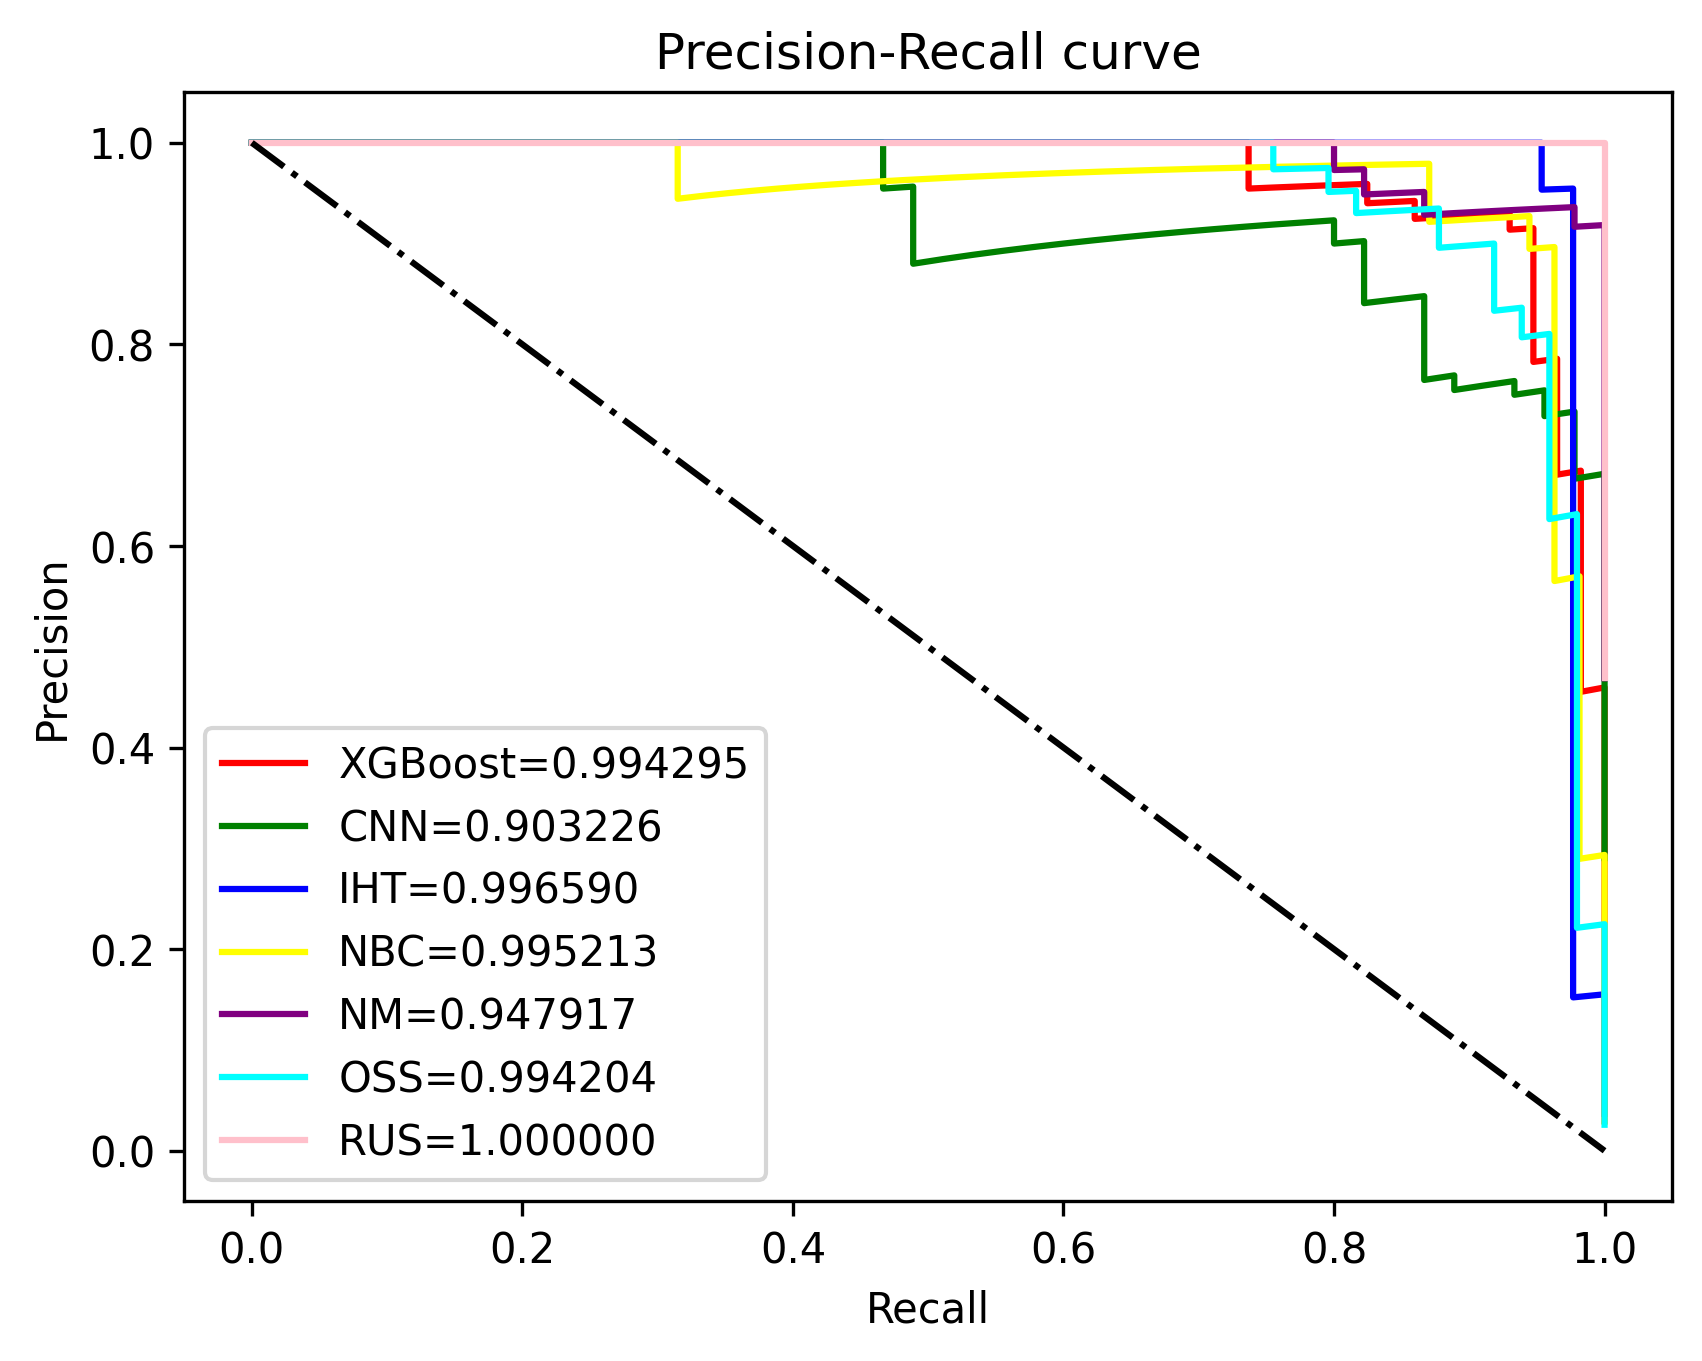

In [57]:
#绘制PR曲线
import matplotlib.pyplot as plt
PR_curve=plt.figure(dpi=300)
PR_ax=PR_curve.add_subplot(111)
PR_ax.set_title('Precision-Recall curve')
PR_ax.plot(XGBoost_PR['recall'], XGBoost_PR['precision'],color='red',label='XGBoost=%f'%XGBoost_Accuracy)
PR_ax.plot(CNN_RF_PR['recall'], CNN_RF_PR['precision'],color='green',label='CNN=%f'%CNN_RF_Accuracy)
PR_ax.plot(IHT_RF_PR['recall'], IHT_RF_PR['precision'],color='blue',label='IHT=%f'%IHT_RF_Accuracy)
PR_ax.plot(NBC_RF_PR['recall'], NBC_RF_PR['precision'],color='yellow',label='NBC=%f'%NBC_RF_Accuracy)
PR_ax.plot(NM_RF_PR['recall'], NM_RF_PR['precision'],color='purple',label='NM=%f'%NM_RF_Accuracy)
PR_ax.plot(OSS_RF_PR['recall'], OSS_RF_PR['precision'],color='cyan',label='OSS=%f'%OSS_RF_Accuracy)
PR_ax.plot(RUS_RF_PR['recall'], RUS_RF_PR['precision'],color='pink',label='RUS=%f'%RUS_RF_Accuracy)
PR_ax.plot([0,1],[1,0],linestyle='-.',color='black')
PR_ax.set_xlabel('Recall')  
PR_ax.set_ylabel('Precision')    
plt.legend(loc="best")  
plt.show()

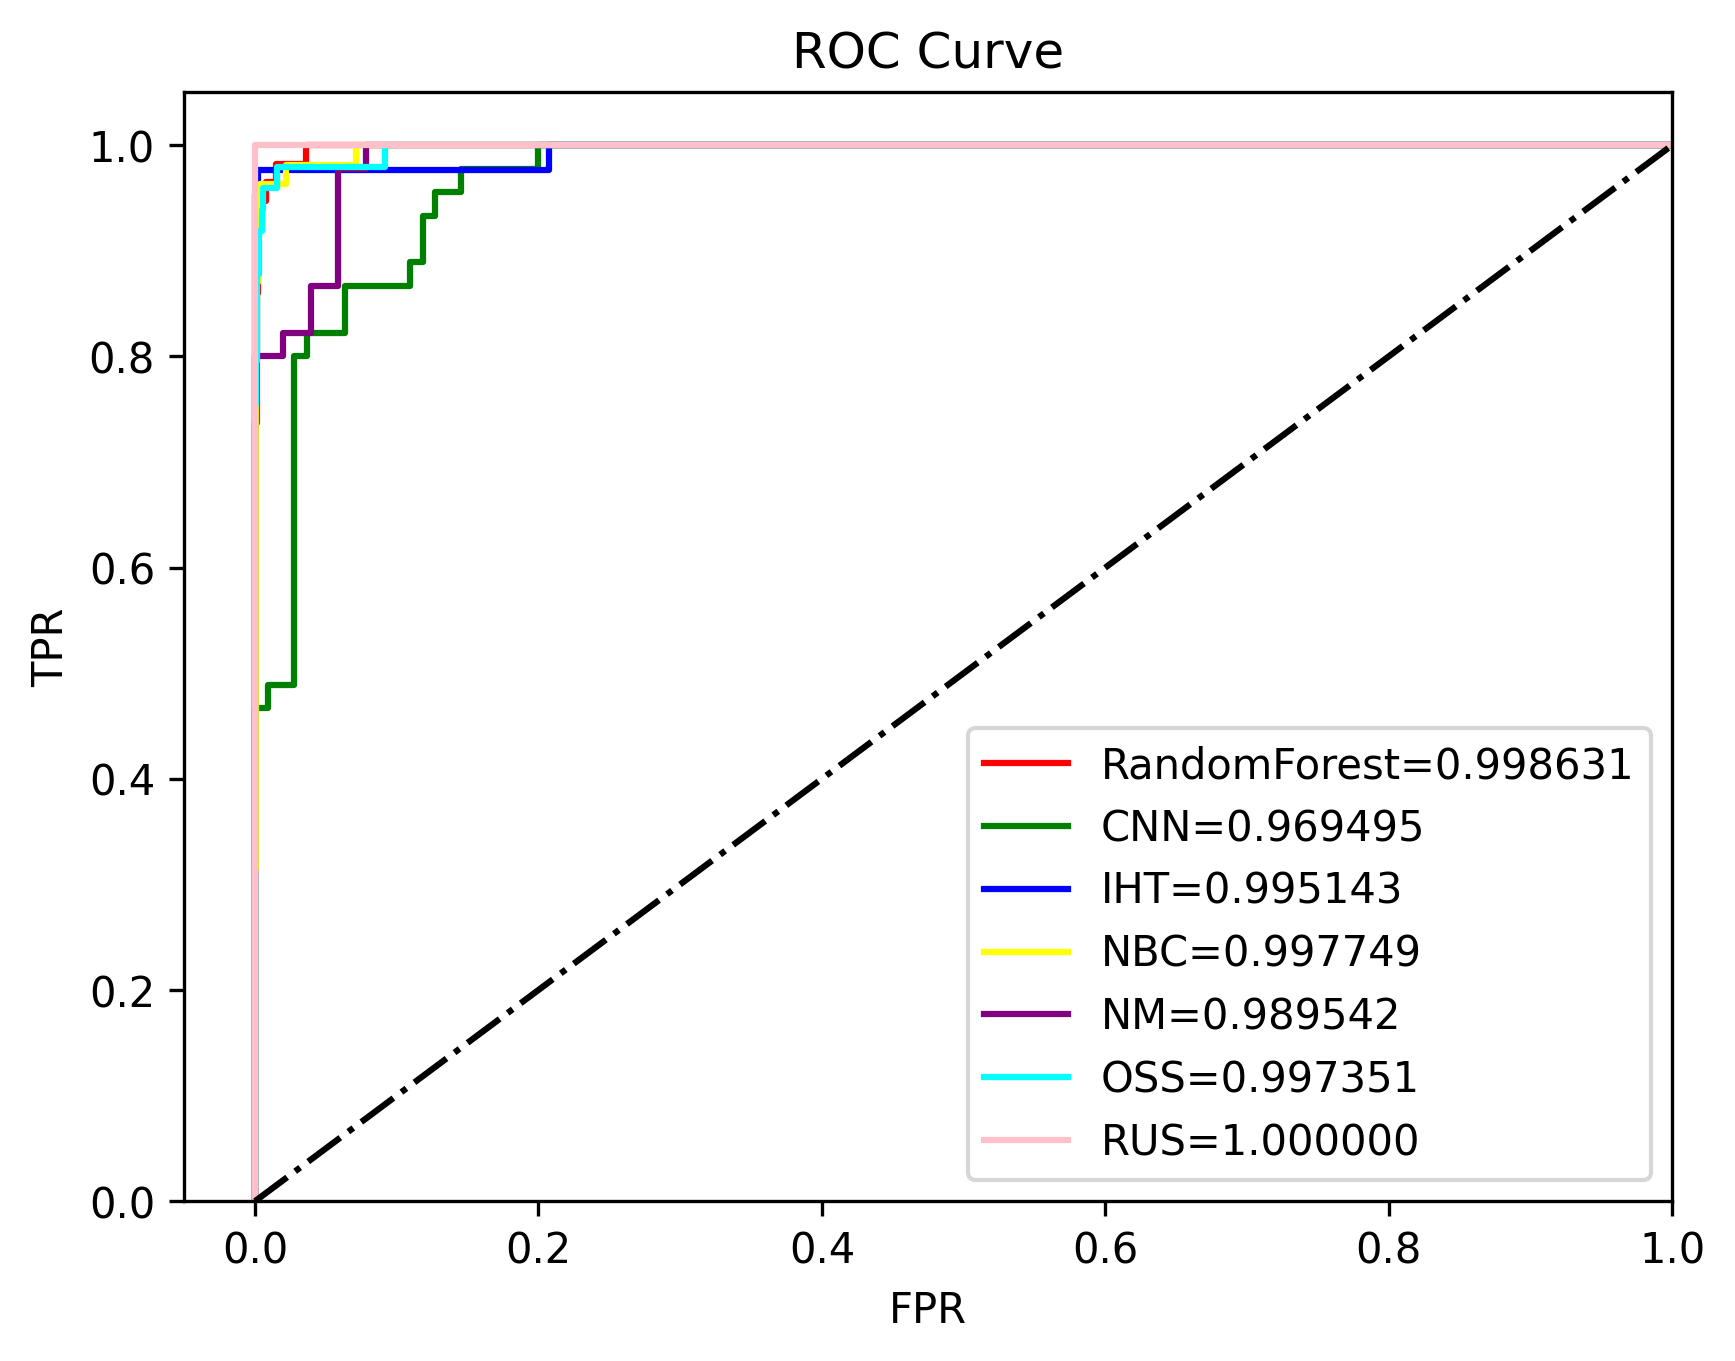

In [58]:
#绘制ROC曲线
import matplotlib.pyplot as plt
ROC_curve=plt.figure(dpi=300)
ROC_ax=ROC_curve.add_subplot(111)
ROC_ax.set_title('ROC Curve')
ROC_ax.plot(XGBoost_ROC['fpr'], XGBoost_ROC['tpr'],color='red',label='XGBoost=%f'%XGBoost_AUC)
ROC_ax.plot(CNN_RF_ROC['fpr'], CNN_RF_ROC['tpr'],color='green',label='CNN=%f'%CNN_RF_AUC)
ROC_ax.plot(IHT_RF_ROC['fpr'], IHT_RF_ROC['tpr'],color='blue',label='IHT=%f'%IHT_RF_AUC)
ROC_ax.plot(NBC_RF_ROC['fpr'], NBC_RF_ROC['tpr'],color='yellow',label='NBC=%f'%NBC_RF_AUC)
ROC_ax.plot(NM_RF_ROC['fpr'], NM_RF_ROC['tpr'],color='purple',label='NM=%f'%NM_RF_AUC)
ROC_ax.plot(OSS_RF_ROC['fpr'], OSS_RF_ROC['tpr'],color='cyan',label='OSS=%f'%OSS_RF_AUC)
ROC_ax.plot(RUS_RF_ROC['fpr'], RUS_RF_ROC['tpr'],color='pink',label='RUS=%f'%RUS_RF_AUC)
ROC_ax.plot([0,1],[0,1],linestyle='-.',color='black')
ROC_ax.set_xlim([-0.05, 1.0])  
ROC_ax.set_ylim([0, 1.05])  
ROC_ax.set_xlabel('FPR')  
ROC_ax.set_ylabel('TPR')    
plt.legend(loc="best")  
plt.show()

In [113]:
import joblib
ResampleModel=[XGBoost,XGBoostCNN,XGBoostIHT,XGBoostNM,XGBoostNBC,XGBoostOSS,XGBoostRUS]
ResampleModelStr=['XGBoost.pkl','XGBoostCNN.pkl','XGBoostIHT.pkl','XGBoostNM.pkl','XGBoostNBC.pkl','XGBoostOSS.pkl','XGBoostRUS.pkl']
try:
    for model,modelstr in zip(ResampleModel,ResampleModelStr):
        joblib.dump(model,'/mnt/workspace/Model test Module/Resample Model/'+modelstr)
    print('模型保存成功！')
except:
    print('模型保存异常！！！')

模型保存成功！


使用随机过采样进行数据预处理，训机器学习算法.

In [76]:
MethylationRUS=MethylationFeature.iloc[:,1:-6]
LabelRUS=MethylationFeature.iloc[:,-1]

In [77]:
#合并过采样结果
RUS=RandomUnderSampler(sampling_strategy='not minority',random_state=2024)
RUS_Methylation,RUS_Label=RUS.fit_resample(MethylationRUS,LabelRUS)
Counter(RUS_Label)

Counter({0: 159, 1: 159})

In [78]:
RUSData=pd.concat([RUS_Methylation,RUS_Label],axis=1)
RUSData.shape

(318, 61)

In [79]:
#输出计算合并结果
RUSData.to_csv('/mnt/workspace/Model test Module/Resample Data/Resample Data/RUS DNA Methylation Data.csv')
RUSData.to_excel('/mnt/workspace/Model test Module/Resample Data/Resample Data/RUS DNA Methylation Data.xlsx','UFT-8')

/tmp/ipykernel_352/2961143546.py:3: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  RUSData.to_excel('/mnt/workspace/Model test Module/Resample Data/Resample Data/RUS DNA Methylation Data.xlsx','UFT-8')


In [80]:
MLFeatureData=RUSData.iloc[:,:-1]
#获取标签数据
ReMLLabel=RUSData.iloc[:,-1]

In [83]:
#数据缩放和标准化
from pandas import DataFrame
from sklearn.preprocessing import StandardScaler,MinMaxScaler
FeatureNames=MLFeatureData.columns    #保存变量名
Standard=StandardScaler()    #标准化数据
StandardData=Standard.fit_transform(MLFeatureData)
MinMax=MinMaxScaler(feature_range=(0,1))    #缩放数据
MinMaxData=MinMax.fit_transform(StandardData)
MLRunData=DataFrame(MinMaxData)
MLRunData.columns=FeatureNames
MLRunData.shape

(318, 60)

编写模型训练和评估函数

In [85]:
#查看模型混淆矩阵
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
def Display_ConfusionMatrix(model,data,target):
    ConfusionMatrix_result=confusion_matrix(target,model.predict(data),labels=[0,1])    #计算混淆举证
    Display_ConfusionMatrix=ConfusionMatrixDisplay(ConfusionMatrix_result,display_labels=['control','rheumatoid arthritis'])
    Display_ConfusionMatrix.plot(include_values=True, cmap='viridis', xticks_rotation='horizontal', values_format='d', ax=None)
    plt.title('Confusion Matrix')
    plt.show()

In [86]:
#计算PR曲线
from pandas import DataFrame
from sklearn.metrics import precision_recall_curve,accuracy_score
def PR_Curve(Model,Data,Label):
    X_train,X_test,y_train,y_test=train_test_split(Data,Label,train_size=0.7,random_state=2025)    #划分数据集
    predict_score=Model.predict_proba(X_test)[:, 1]    #获取概率值
    predict=Model.predict(X_test)     #获取预测标签
    accuracy=accuracy_score(y_test,predict)
    precision, recall, thresholds = precision_recall_curve(y_test, predict_score)    #计算PR曲线
    PR=DataFrame()    #将PR曲线数据合并到DataFrame
    #PR['thresholds']=thresholds
    PR['recall']=recall
    PR['precision']=precision
    return PR,accuracy

In [87]:
#计算ROC曲线
from sklearn.metrics import roc_curve, auc
def ROC_Curve(Model,Data,Label):
    X_train,X_test,y_train,y_test=train_test_split(Data,Label,train_size=0.7,random_state=2025)    #划分数据集
    predict_score=Model.predict_proba(X_test)[:, 1]    #获取概率值
    fpr, tpr, thresholds = roc_curve(y_test, predict_score)
    roc_auc = auc(fpr, tpr)    #计算AUC
    ROC=DataFrame()    #将PR曲线数据合并到DataFrame
    #ROC['thresholds']=thresholds
    ROC['tpr']=tpr
    ROC['fpr']=fpr
    return ROC,roc_auc

In [88]:
#模型训练评估函数
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
def RunMLModel(Model,Data,Label):
    X_train,X_test,y_train,y_test=train_test_split(Data,Label,train_size=0.7,random_state=2025)    #划分数据集
    Model.fit(X_train,y_train)    #训练模型
    TrainPredict=Model.predict(X_train)    #计算训练集指标
    TrainPrecision=precision_score(y_train,TrainPredict)
    TrainRecall=recall_score(y_train,TrainPredict)
    TrainF1=f1_score(y_train,TrainPredict)
    TrainAcuracy=accuracy_score(y_train,TrainPredict)
    print('模型训练集Precision:{0},Recall:{1},F1_Score:{2},Accuracy:{3}'.format(TrainPrecision,TrainRecall,TrainF1,TrainAcuracy))
    TestPredict=Model.predict(X_test)    #测试集预测结果
    TestPrecision=precision_score(y_test,TestPredict)
    TestRecall=recall_score(y_test,TestPredict)
    TestF1=f1_score(y_test,TestPredict)
    TestAccuracy=accuracy_score(y_test,TestPredict)
    print('模型测试集Precision:{0},Recall:{1},F1_score:{2},Accuracy:{3}'.format(TestPrecision,TestRecall,TestF1,TestAccuracy))
    print('-------------------测试集混淆举证-------------------')
    Display_ConfusionMatrix(model=Model,data=X_test,target=y_test)

模型训练集Precision:0.8934426229508197,Recall:0.956140350877193,F1_Score:0.923728813559322,Accuracy:0.918918918918919
模型测试集Precision:0.9166666666666666,Recall:0.9777777777777777,F1_score:0.946236559139785,Accuracy:0.9479166666666666
-------------------测试集混淆举证-------------------


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


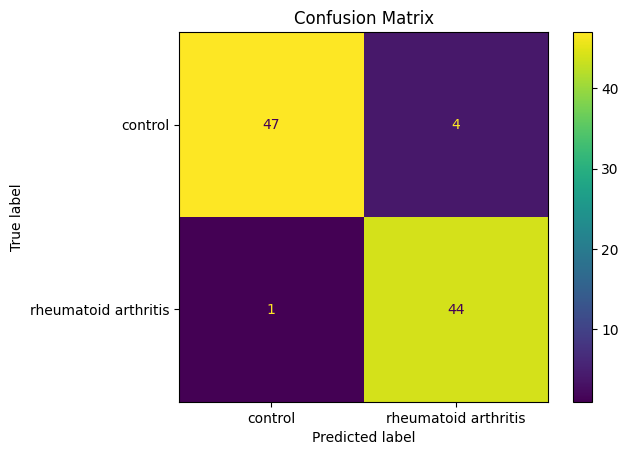

In [90]:
#测试Logistic回归
from sklearn.linear_model import LogisticRegression
ReLogistic=LogisticRegression(penalty="l2",dual=True,tol=1e-4,C=1.0,fit_intercept=True,random_state=2024,solver='liblinear',
                            max_iter=100,multi_class="auto",verbose=0, warm_start=False,n_jobs=-1,l1_ratio=None)
RunMLModel(Model=ReLogistic,Data=MLRunData,Label=ReMLLabel)

In [ ]:
#计算PR曲线和ROC曲线值
ReLogistic_PR,ReLogistic_Accuracy=PR_Curve(Model=ReLogistic,Data=MLRunData,Label=ReMLLabel)    
ReLogistic_ROC,ReLogistic_AUC=ROC_Curve(Model=ReLogistic,Data=MLRunData,Label=ReMLLabel)
#输出PR曲线和ROC曲线结果
ReLogistic_PR.to_excel('/mnt/workspace/Model test Module/Resample Data/ML PR Curve/Logistic_PR.xlsx','UTF-8')
ReLogistic_ROC.to_excel('/mnt/workspace/Model test Module/Resample Data/ML ROC Curve/Logistic_ROC.xlsx','UTF-8')

模型训练集Precision:0.8790322580645161,Recall:0.956140350877193,F1_Score:0.9159663865546218,Accuracy:0.9099099099099099
模型测试集Precision:0.9361702127659575,Recall:0.9777777777777777,F1_score:0.9565217391304348,Accuracy:0.9583333333333334
-------------------测试集混淆举证-------------------


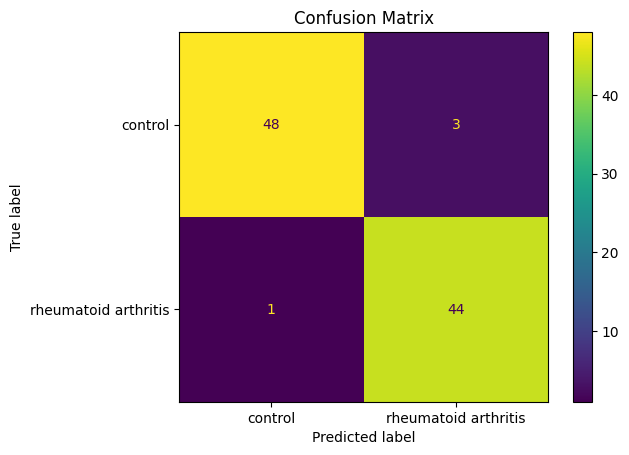

In [92]:
#测试SVM算法
from sklearn.svm import SVC
ReSVM_Classifier=SVC(C=1.0,kernel="rbf",degree=3,gamma="scale",coef0=0.0,shrinking=True,probability=True,tol=1e-3, 
                   cache_size=200,max_iter=-1, decision_function_shape="ovr",random_state=2024)
RunMLModel(Model=ReSVM_Classifier,Data=MLRunData,Label=ReMLLabel)

In [ ]:
#计算PR曲线和ROC曲线值
ReSVM_PR,ReSVM_Accuracy=PR_Curve(Model=ReSVM_Classifier,Data=MLRunData,Label=ReMLLabel)    
ReSVM_ROC,ReSVM_AUC=ROC_Curve(Model=ReSVM_Classifier,Data=MLRunData,Label=ReMLLabel)
#输出PR曲线和ROC曲线结果
ReSVM_PR.to_excel('/mnt/workspace/Model test Module/Resample Data/ML PR Curve/ReSVM_PR.xlsx','UTF-8')
ReSVM_ROC.to_excel('/mnt/workspace/Model test Module/Resample Data/ML ROC Curve/ReSVM_ROC.xlsx','UTF-8')

In [ ]:
#测试决策树算法
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
ReDecisionTree=DecisionTreeClassifier(criterion='gini',splitter='best',max_depth=10,min_samples_split=2,random_state=2024)
ReResearch_params={'max_depth':np.arange(1,20,1,dtype=int),'min_samples_split':np.arange(1,20,1,dtype=int),
                 'criterion':['gini','entropy']}    #超参数列表
ReGridSearch=GridSearchCV(estimator=ReDecisionTree,param_grid=ReResearch_params,cv=5,
                        scoring='accuracy',return_train_score=True,n_jobs=-1,verbose=0)
ReGridSearch.fit(MLRunData,ReMLLabel)
print('超参数搜索最佳超参数为；',ReGridSearch.best_params_)
print('超参数搜索最佳得分为:',ReGridSearch.best_score_)
ReBest_DTC=ReGridSearch.best_estimator_

超参数搜索最佳超参数为； {'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 10}

超参数搜索最佳得分为: 0.8738095238095237

模型训练集Precision:1.0,Recall:0.9824561403508771,F1_Score:0.9911504424778761,Accuracy:0.990990990990991
模型测试集Precision:0.8913043478260869,Recall:0.9111111111111111,F1_score:0.9010989010989011,Accuracy:0.90625
-------------------测试集混淆举证-------------------


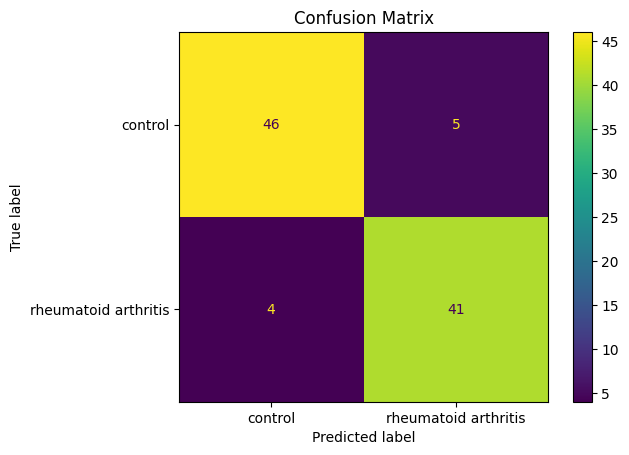

In [95]:
RunMLModel(Model=ReBest_DTC,Data=MLRunData,Label=ReMLLabel)

In [ ]:
#计算PR曲线和ROC曲线值
ReDTC_PR,ReDTC_Accuracy=PR_Curve(Model=ReBest_DTC,Data=MLRunData,Label=ReMLLabel)    
ReDTC_ROC,ReDTC_AUC=ROC_Curve(Model=ReBest_DTC,Data=MLRunData,Label=ReMLLabel)
#输出PR曲线和ROC曲线结果
ReDTC_PR.to_excel('/mnt/workspace/Model test Module/Resample Data/ML PR Curve/ReDTC_PR.xlsx','UTF-8')
ReDTC_ROC.to_excel('/mnt/workspace/Model test Module/Resample Data/ML ROC Curve/ReDTC_ROC.xlsx','UTF-8')

In [ ]:
#对随机森林进行网格搜索
from sklearn.ensemble import RandomForestClassifier
ReRandomForest=RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=7,min_samples_split=6,
                                    bootstrap=True,min_samples_leaf=2,max_features='auto',random_state=2024)
ReRandomForest_params={'n_estimators':np.arange(1,40,2,dtype=int),'min_samples_leaf':np.arange(1,40,2,dtype=int),
                     'max_features':['auto','sqrt'],'criterion':['gini','entropy']}
ReGridSearch_RandomForest=GridSearchCV(estimator=ReRandomForest,param_grid=ReRandomForest_params,cv=5,
                        scoring='accuracy',return_train_score=False,n_jobs=-1,verbose=0)
ReGridSearch_RandomForest.fit(MLRunData,ReMLLabel)
print('超参数搜索最佳超参数为；',ReGridSearch_RandomForest.best_params_)
print('超参数搜索最佳得分为:',ReGridSearch_RandomForest.best_score_)
ReBest_Forest=ReGridSearch_RandomForest.best_estimator_

超参数搜索最佳超参数为； {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 21}

超参数搜索最佳得分为: 0.952579365079365

模型训练集Precision:0.9911504424778761,Recall:0.9824561403508771,F1_Score:0.986784140969163,Accuracy:0.9864864864864865
模型测试集Precision:0.9047619047619048,Recall:0.8444444444444444,F1_score:0.8735632183908046,Accuracy:0.8854166666666666
-------------------测试集混淆举证-------------------


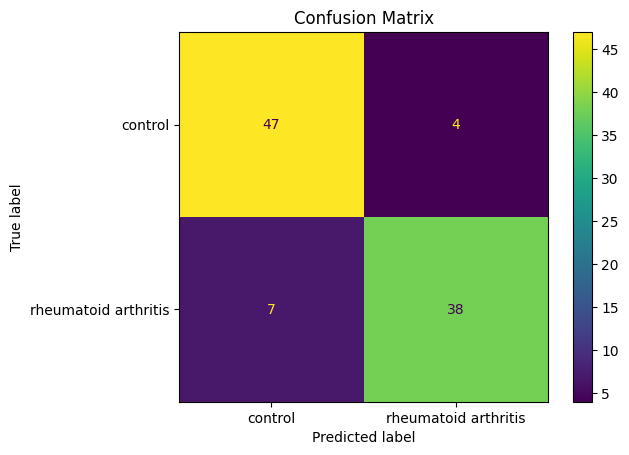

In [99]:
#评估最佳模型
RunMLModel(Model=ReBest_Forest,Data=MLRunData,Label=ReMLLabel)

In [ ]:
#计算PR曲线和ROC曲线值
ReRondomForest_PR,ReRondomForest_Accuracy=PR_Curve(Model=ReBest_Forest,Data=MLRunData,Label=ReMLLabel)    
ReRondomForest_ROC,ReRondomForest_AUC=ROC_Curve(Model=ReBest_Forest,Data=MLRunData,Label=ReMLLabel)
#输出PR曲线和ROC曲线结果
ReRondomForest_PR.to_excel('/mnt/workspace/Model test Module/Resample Data/ML PR Curve/ReRondomForest_PR.xlsx','UTF-8')
ReRondomForest_ROC.to_excel('/mnt/workspace/Model test Module/Resample Data/ML ROC Curve/ReRondomForest_ROC.xlsx','UTF-8')

模型训练集Precision:1.0,Recall:1.0,F1_Score:1.0,Accuracy:1.0
模型测试集Precision:0.875,Recall:0.9333333333333333,F1_score:0.9032258064516129,Accuracy:0.90625
-------------------测试集混淆举证-------------------


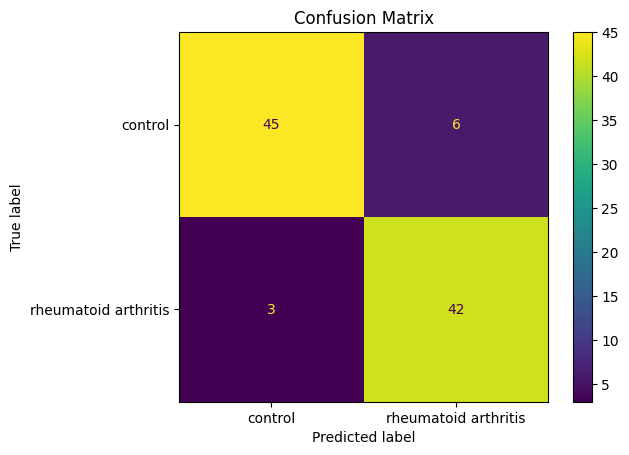

In [101]:
#测试XGBoost模型
from xgboost import XGBClassifier
ReXGBoost=XGBClassifier(n_jobs=-1,verbosity=1,tree_method='auto',gpu_id=0,random_state=2025)
RunMLModel(Model=ReXGBoost,Data=MLRunData,Label=ReMLLabel)

In [ ]:
#计算PR曲线和ROC曲线值
ReXGBoost_PR,ReXGBoost_Accuracy=PR_Curve(Model=ReXGBoost,Data=MLRunData,Label=ReMLLabel)    
ReXGBoost_ROC,ReXGBoost_AUC=ROC_Curve(Model=ReXGBoost,Data=MLRunData,Label=ReMLLabel)
#输出PR曲线和ROC曲线结果
ReXGBoost_PR.to_excel('/mnt/workspace/Model test Module/Resample Data/ML PR Curve/ReXGBoost_PR.xlsx','UTF-8')
ReXGBoost_ROC.to_excel('/mnt/workspace/Model test Module/Resample Data/ML ROC Curve/ReXGBoost_ROC.xlsx','UTF-8')

[LightGBM] [Warning] Unknown parameter: keep_training_booster
[LightGBM] [Warning] Unknown parameter: keep_training_booster
[LightGBM] [Info] Number of positive: 114, number of negative: 108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2827
[LightGBM] [Info] Number of data points in the train set: 222, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513514 -> initscore=0.054067
[LightGBM] [Info] Start training from score 0.054067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

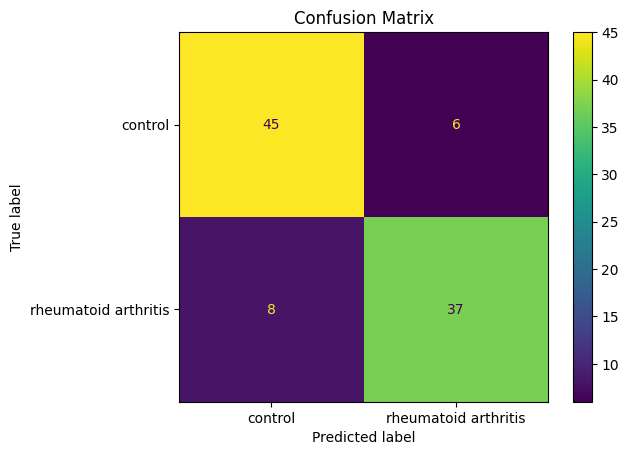

In [104]:
#测试LightGBM算法
from lightgbm import LGBMClassifier
ReLightGBM=LGBMClassifier(boosting_type='gbdt',num_leaves=31,learning_rate=0.01,n_estimators=200,
                        n_jobs=-1,objective='binary',metric='binary_logloss',keep_training_booster=True,
                       importance_type='gini',random_state=2025)
RunMLModel(Model=ReLightGBM,Data=MLRunData,Label=ReMLLabel)

In [ ]:
#计算PR曲线和ROC曲线值
ReLightGBM_PR,ReLightGBM_Accuracy=PR_Curve(Model=ReLightGBM,Data=MLRunData,Label=ReMLLabel)    
ReLightGBM_ROC,ReLightGBM_AUC=ROC_Curve(Model=ReLightGBM,Data=MLRunData,Label=ReMLLabel)
#输出PR曲线和ROC曲线结果
ReLightGBM_PR.to_excel('/mnt/workspace/Model test Module/Resample Data/ML PR Curve/ReLightGBM_PR.xlsx','UTF-8')
ReLightGBM_ROC.to_excel('/mnt/workspace/Model test Module/Resample Data/ML ROC Curve/ReLightGBM_ROC.xlsx','UTF-8')

0:	learn: 0.6841967	total: 1.96ms	remaining: 977ms
1:	learn: 0.6737406	total: 3.47ms	remaining: 863ms
2:	learn: 0.6653478	total: 4.8ms	remaining: 795ms
3:	learn: 0.6579565	total: 6.14ms	remaining: 762ms
4:	learn: 0.6509925	total: 7.45ms	remaining: 738ms
5:	learn: 0.6435066	total: 8.81ms	remaining: 725ms
6:	learn: 0.6336743	total: 10.1ms	remaining: 711ms
7:	learn: 0.6254949	total: 11.4ms	remaining: 702ms
8:	learn: 0.6157519	total: 12.7ms	remaining: 691ms
9:	learn: 0.6068198	total: 14ms	remaining: 688ms
10:	learn: 0.5993857	total: 15.4ms	remaining: 683ms
11:	learn: 0.5931684	total: 16.7ms	remaining: 679ms
12:	learn: 0.5860873	total: 18ms	remaining: 675ms
13:	learn: 0.5789316	total: 19.3ms	remaining: 671ms
14:	learn: 0.5701797	total: 20.7ms	remaining: 668ms
15:	learn: 0.5629747	total: 22ms	remaining: 665ms
16:	learn: 0.5573673	total: 23.2ms	remaining: 660ms
17:	learn: 0.5504202	total: 24.6ms	remaining: 658ms
18:	learn: 0.5432051	total: 25.9ms	remaining: 655ms
19:	learn: 0.5353658	total: 2

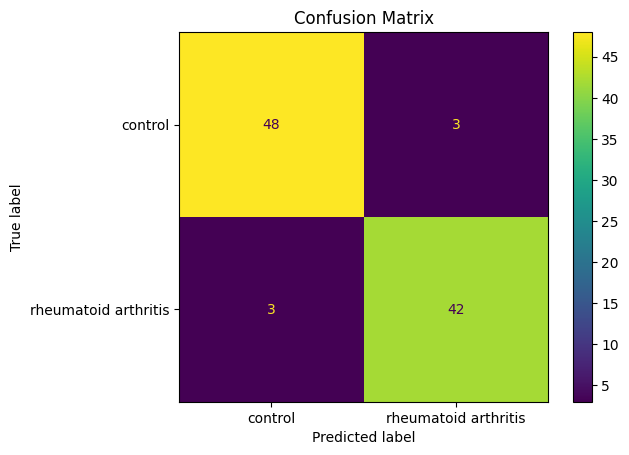

In [106]:
#测试CatBoost算法
from catboost import CatBoostClassifier
ReCatBoost=CatBoostClassifier(learning_rate=0.01,depth=6,iterations=500,thread_count=-1)
RunMLModel(Model=ReCatBoost,Data=MLRunData,Label=ReMLLabel)

In [ ]:
#计算PR曲线和ROC曲线值
ReCatBoost_PR,ReCatBoost_Accuracy=PR_Curve(Model=ReCatBoost,Data=MLRunData,Label=ReMLLabel)    
ReCatBoost_ROC,ReCatBoost_AUC=ROC_Curve(Model=ReCatBoost,Data=MLRunData,Label=ReMLLabel)
#输出PR曲线和ROC曲线结果
ReCatBoost_PR.to_excel('/mnt/workspace/Model test Module/Resample Data/ML PR Curve/ReCatBoost_PR.xlsx','UTF-8')
ReCatBoost_ROC.to_excel('/mnt/workspace/Model test Module/Resample Data/ML ROC Curve/ReCatBoost_ROC.xlsx','UTF-8')

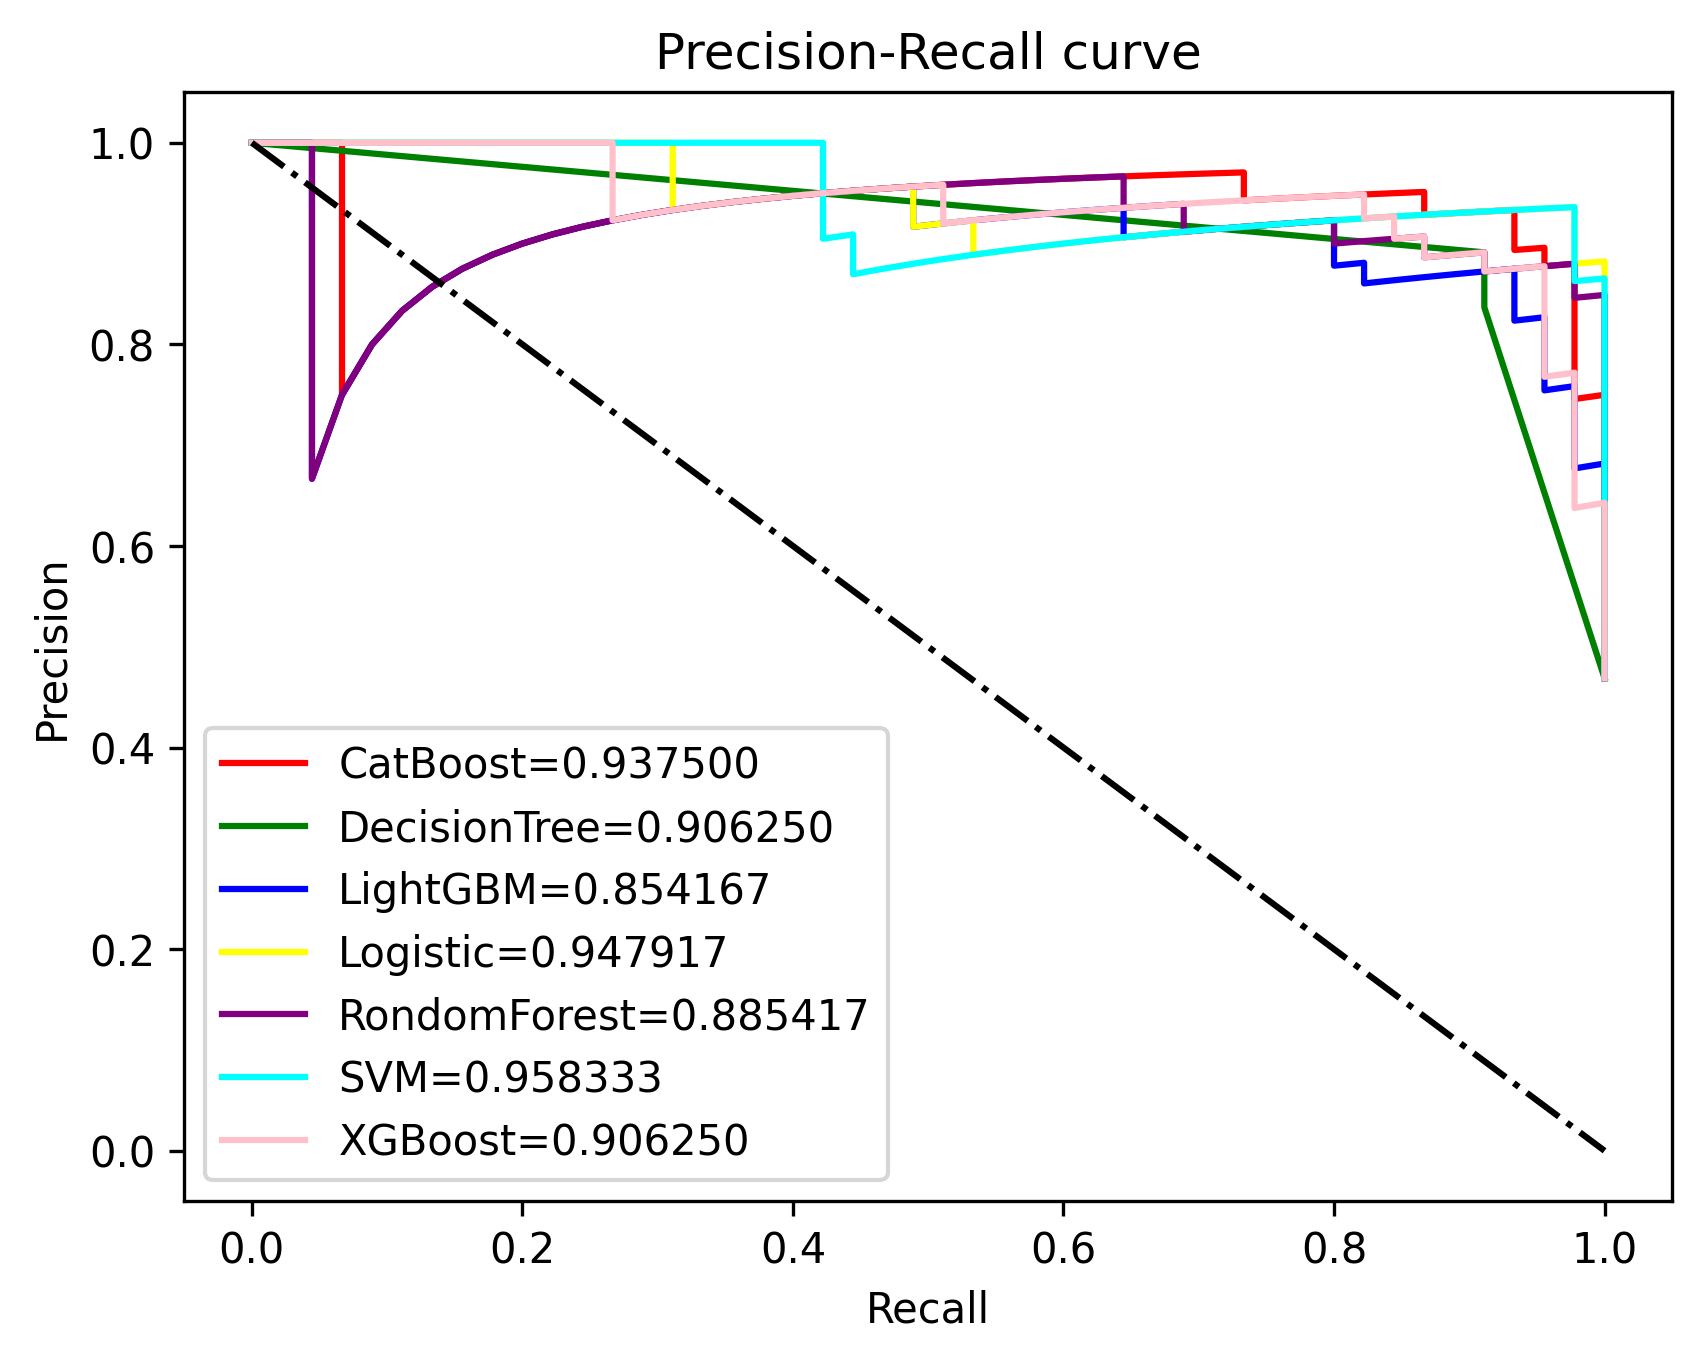

In [109]:
#绘制PR曲线
import matplotlib.pyplot as plt
PR_curve=plt.figure(dpi=300)
PR_ax=PR_curve.add_subplot(111)
PR_ax.set_title('Precision-Recall curve')
PR_ax.plot(ReCatBoost_PR['recall'], ReCatBoost_PR['precision'],color='red',label='CatBoost=%f'%ReCatBoost_Accuracy)
PR_ax.plot(ReDTC_PR['recall'], ReDTC_PR['precision'],color='green',label='DecisionTree=%f'%ReDTC_Accuracy)
PR_ax.plot(ReLightGBM_PR['recall'], ReLightGBM_PR['precision'],color='blue',label='LightGBM=%f'%ReLightGBM_Accuracy)
PR_ax.plot(ReLogistic_PR['recall'], ReLogistic_PR['precision'],color='yellow',label='Logistic=%f'%ReLogistic_Accuracy)
PR_ax.plot(ReRondomForest_PR['recall'], ReRondomForest_PR['precision'],color='purple',label='RondomForest=%f'%ReRondomForest_Accuracy)
PR_ax.plot(ReSVM_PR['recall'], ReSVM_PR['precision'],color='cyan',label='SVM=%f'%ReSVM_Accuracy)
PR_ax.plot(ReXGBoost_PR['recall'], ReXGBoost_PR['precision'],color='pink',label='XGBoost=%f'%ReXGBoost_Accuracy)
PR_ax.plot([0,1],[1,0],linestyle='-.',color='black')
PR_ax.set_xlabel('Recall')  
PR_ax.set_ylabel('Precision')    
plt.legend(loc="best")  
plt.show()

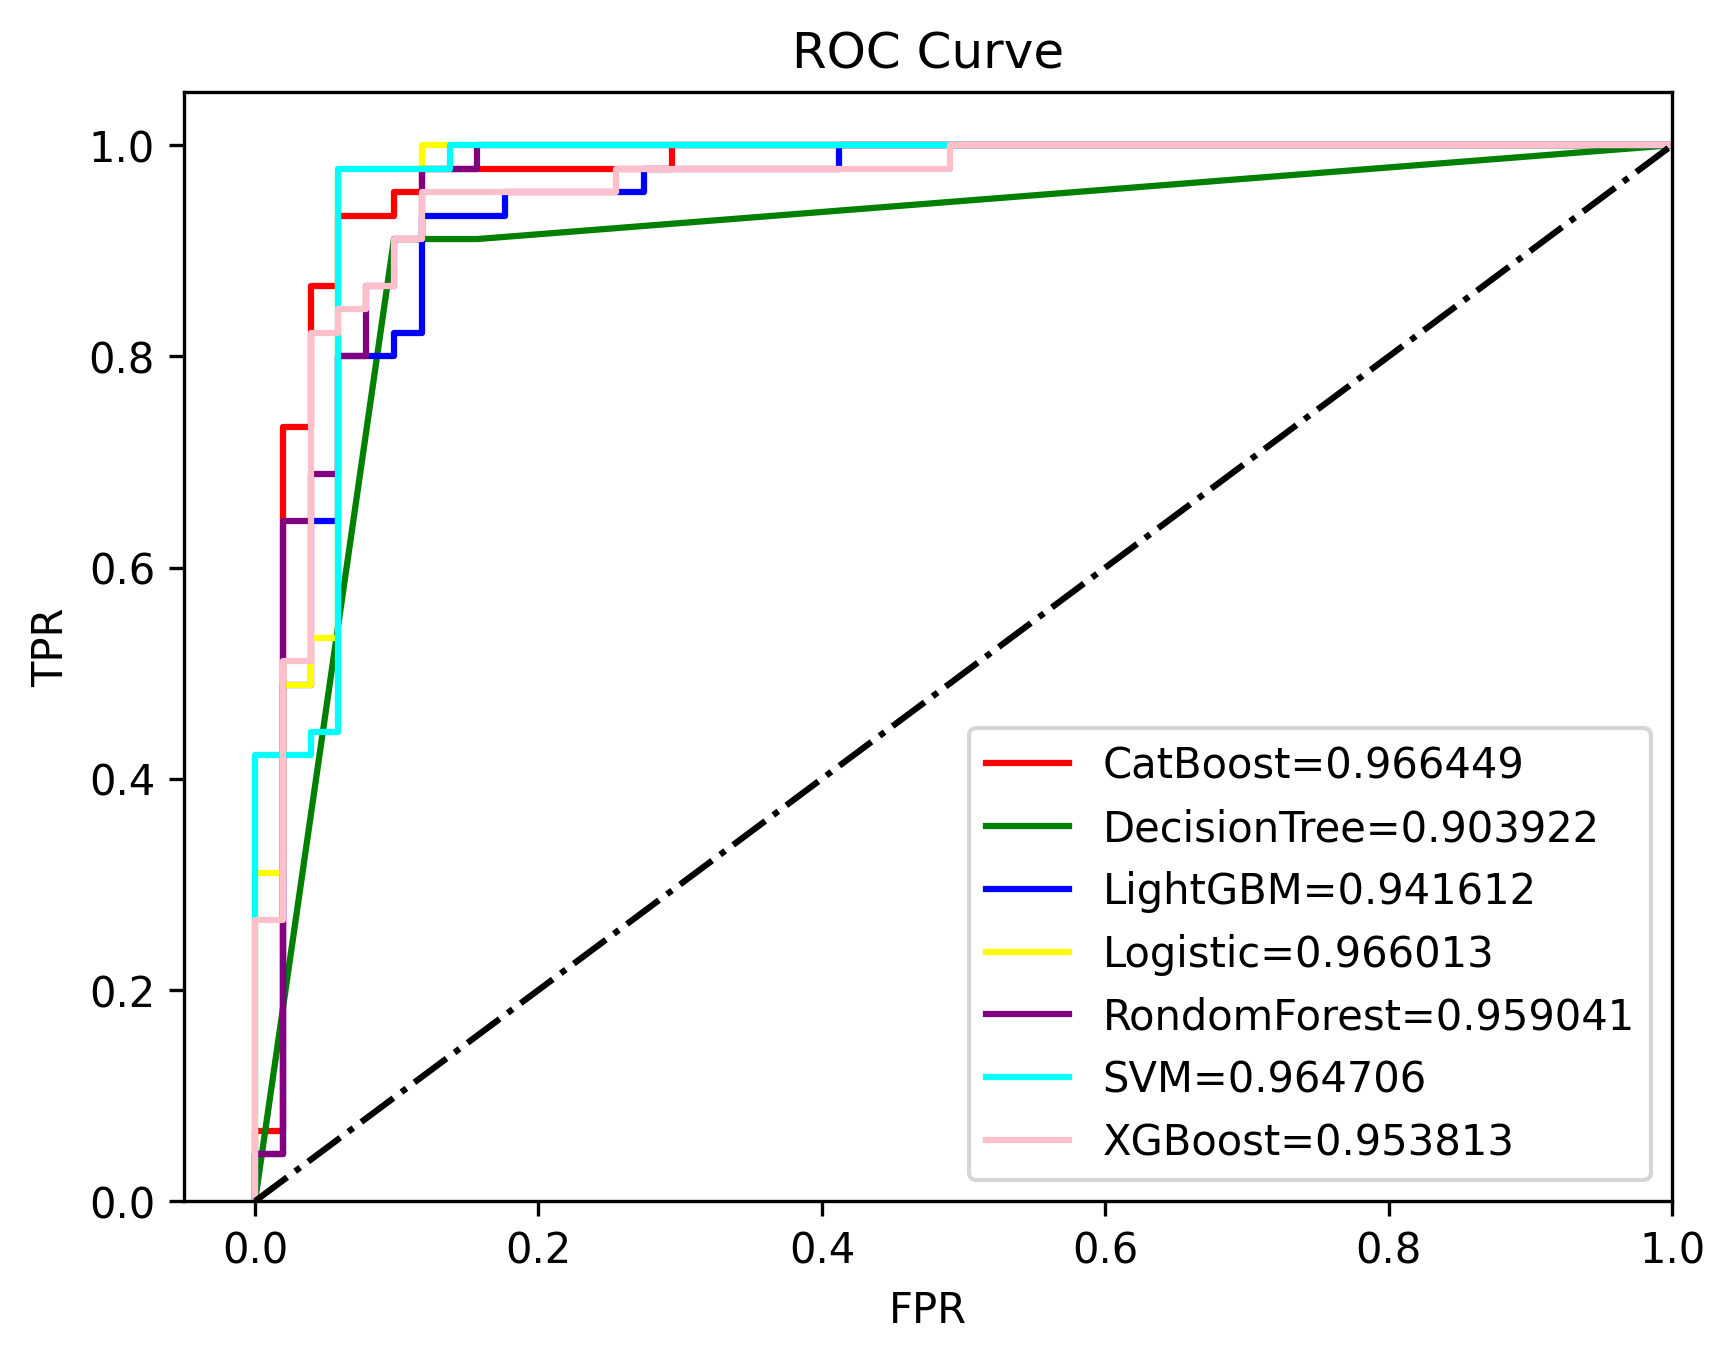

In [110]:
#绘制ROC曲线
import matplotlib.pyplot as plt
ROC_curve=plt.figure(dpi=300)
ROC_ax=ROC_curve.add_subplot(111)
ROC_ax.set_title('ROC Curve')
ROC_ax.plot(ReCatBoost_ROC['fpr'], ReCatBoost_ROC['tpr'],color='red',label='CatBoost=%f'%ReCatBoost_AUC)
ROC_ax.plot(ReDTC_ROC['fpr'], ReDTC_ROC['tpr'],color='green',label='DecisionTree=%f'%ReDTC_AUC)
ROC_ax.plot(ReLightGBM_ROC['fpr'], ReLightGBM_ROC['tpr'],color='blue',label='LightGBM=%f'%ReLightGBM_AUC)
ROC_ax.plot(ReLogistic_ROC['fpr'], ReLogistic_ROC['tpr'],color='yellow',label='Logistic=%f'%ReLogistic_AUC)
ROC_ax.plot(ReRondomForest_ROC['fpr'], ReRondomForest_ROC['tpr'],color='purple',label='RondomForest=%f'%ReRondomForest_AUC)
ROC_ax.plot(ReSVM_ROC['fpr'], ReSVM_ROC['tpr'],color='cyan',label='SVM=%f'%ReSVM_AUC)
ROC_ax.plot(ReXGBoost_ROC['fpr'], ReXGBoost_ROC['tpr'],color='pink',label='XGBoost=%f'%ReXGBoost_AUC)
ROC_ax.plot([0,1],[0,1],linestyle='-.',color='black')
ROC_ax.set_xlim([-0.05, 1.0])  
ROC_ax.set_ylim([0, 1.05])  
ROC_ax.set_xlabel('FPR')  
ROC_ax.set_ylabel('TPR')    
plt.legend(loc="best")  
plt.show()

In [112]:
import joblib
ReMLModel=[ReLogistic,ReSVM_Classifier,ReBest_DTC,ReBest_Forest,ReXGBoost,ReLightGBM,ReCatBoost]
ReMLModelStr=['ReLogistic.pkl','ReSVM.pkl','ReDecisionTree.pkl','ReForest.pkl','ReXGBoost.pkl','ReLightGBM.pkl','ReCatBoost.pkl']
try:
    for model,modelstr in zip(ReMLModel,ReMLModelStr):
        joblib.dump(model,'/mnt/workspace/Model test Module/Resample Model/Re Ml Moels/'+modelstr)
    print('模型保存成功！')
except:
    print('模型保存异常！！！')

模型保存成功！
